In [1]:
import random
import os
from datetime import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

In [46]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(42)

In [47]:
CFG = {
    'TRAIN_WINDOW_SIZE':60, # 30일치로 학습
    'PREDICT_SIZE':40, # 10일치 예측
    'EPOCHS':100,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':256,
    'SEED':41, 
    'SPLIT_RATE':0.8, 
    'MIN_DELTA':0.001 , 
    'PATIENCE':20  
    
}

In [48]:
samsung =pd.read_csv('../data/삼성전자.csv')[['Date','Close','Volume']]
extrainfo= pd.read_csv('../data/extra_info.csv')
extrainfo = extrainfo.iloc[1:, :]
extrainfo = extrainfo[['날짜','개인','외국인','기관계','기타법인']].rename(columns={'날짜':'Date', '개인':'individ', '외국인':'foreign','기관계':'institute', '기타법인':'extras'})
extrainfo = extrainfo[ ::-1 ].reset_index(drop=True)
extrainfo['Date'] = pd.to_datetime(extrainfo['Date'],format='%y.%m.%d' )
samsung['Date']  =pd.to_datetime(samsung['Date'])

data  = samsung.merge(extrainfo, on='Date', how = 'left')
data[['individ', 'foreign', 'institute', 'extras']] =data[['individ', 'foreign', 'institute', 'extras']].astype(float)
# data = data.set_index('Date').transpose() 
data  = data[['Volume','individ','foreign','institute','extras','Close']]
train = data.iloc[ :-(CFG['PREDICT_SIZE']), :]
vaild = data.iloc[-(CFG['PREDICT_SIZE']): , : ]
train = train.T 


In [49]:
# Class Definitions
# iTransformer 

from layers.Transformer_EncDec import Encoder, EncoderLayer
from layers.SelfAttention_Family import FullAttention, AttentionLayer
from layers.Embed import DataEmbedding_inverted
class Model(nn.Module):
    def __init__(self, configs):
        super(Model, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.output_attention = configs.output_attention
        self.use_norm = configs.use_norm
        # Embedding
        self.enc_embedding =DataEmbedding_inverted(configs.seq_len, configs.d_model, configs.embed, configs.freq,
                                                    configs.dropout)
        
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(
                        FullAttention(False, configs.factor, attention_dropout=configs.dropout, output_attention=configs.output_attention), configs.d_model, configs.n_heads),
                    configs.d_model,
                    configs.d_ff,
                    dropout=configs.dropout,
                    activation=configs.activation
                ) for l in range(configs.e_layers)
            ],
            norm_layer=torch.nn.LayerNorm(configs.d_model)
        )
        self.projector = nn.Linear(configs.d_model, configs.pred_len, bias=True)

    def forecast(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
        if self.use_norm:
            # Normalization from Non-stationary Transformer
            means = x_enc.mean(1, keepdim=True).detach()
            x_enc = x_enc - means
            stdev = torch.sqrt(torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5)
            x_enc /= stdev
        # print(f"{x_enc.shape} : 입력데이터 형태 ")
        _, _, N = x_enc.shape # B L N
        # B: batch_size;    E: d_model; 
        # L: seq_len;       S: pred_len;
        # N: number of variate (tokens), can also includes covariates

        # Embedding
        # B L N -> B N E                (B L N -> B L E in the vanilla Transformer)
        enc_out = self.enc_embedding(x_enc, x_mark_enc) # covariates (e.g timestamp) can be also embedded as tokens
        # print(f"{enc_out.shape} : 임베딩 이후의 형태  ")
        # B N E -> B N E                (B N E -> B N E in the vanilla Transformer)
        # the dimensions of embedded time series has been inverted, and then processed by native attn, layernorm and ffn modules
        enc_out, attns = self.encoder(enc_out, attn_mask=None)
        # print(f"{enc_out.shape} : 인코더  이후의 형태  ")
        # B N E -> B N S -> B S N 
        dec_out = self.projector(enc_out).permute(0, 2, 1)[:, :, :N] # filter the covariates
        # print(f"{dec_out.shape} : 디코더 이후의 형태  ")
        if self.use_norm:
            # De-Normalization from Non-stationary Transformer
            dec_out = dec_out * (stdev[:, 0, :].unsqueeze(1).repeat(1, self.pred_len, 1))
            dec_out = dec_out + (means[:, 0, :].unsqueeze(1).repeat(1, self.pred_len, 1))

        return dec_out


    def forward(self, x_enc,  x_dec=None, x_mark_dec=None, mask=None,x_mark_enc=None):
        dec_out = self.forecast(x_enc, x_mark_enc, x_dec, x_mark_dec)
        return dec_out[:, -self.pred_len:, :]  # [B, L, D]

class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [50]:
# 데이터 형성 
def reshape_data(df):
    time_series_data = []
    for idx, row in df.iterrows():
        sales_data = row[0:].values.astype(float)
        time_series_data.append(sales_data)
    return np.array(time_series_data)

# Modified time_slide_df function to work with the current data format
def time_slide_df(data, window_size, forecast_size):
    data_list = []
    dap_list = []
    # len(data) = 1523 (데이터 전체에 몇 일치의 데이터인지 ), windowsize=72 (72일을 보고나서 28일을 예측하겠다), forecastsize = 28 
    # data_list = 1424x72  의 형태이다, dap_list =1424x 28 의 형태이다 즉, 하나의 제품에 대해서 1424개의 학습 데이터 셋이 만들어 진 것이다. 
    for idx in range(0, len(data) - window_size - forecast_size + 1):
        x = data[idx:idx + window_size].reshape(window_size, 1)
        
        y = data[idx + window_size:idx + window_size + forecast_size]
        data_list.append(x)
        dap_list.append(y)
    # print(f"{len(data_list)} is shape of x and {len(dap_list)} is shape of y , {len(data) }")
    # print(dap_list)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32')

# Function to create DataLoader for each ID
def create_dataloader(data, window_size, forecast_size, batch_size):
    X, Y = time_slide_df(data, window_size, forecast_size)
    ds = Data(X, Y)
    # print(ds())
    return DataLoader(ds, batch_size=batch_size, shuffle=True)

# 특산물의 메타 데이터는 버리고 일별 가격 정보만 갖고오기 
time_series_data = reshape_data(train)

epoch_count = 100
lr = 0.001
min_delta = 0.001
patience = 10
# 데이터 표준화
means = np.mean(time_series_data, axis=1, keepdims=True)
stds = np.std(time_series_data, axis=1, keepdims=True)
standardized_data = (time_series_data - means) / stds

# DataLoader 생성 함수 수정
from torch.utils.data import DataLoader, TensorDataset
def create_dataloader(data, train_window_size, predict_size, batch_size):
    sequences = []
    targets = []
    for i in range(data.shape[1] - train_window_size - predict_size + 1):
        seq = data[:, i:i + train_window_size]
        target = data[:, i + train_window_size:i + train_window_size + predict_size]
        sequences.append(seq)
        targets.append(target)
    sequences = np.stack(sequences)
    targets = np.stack(targets)
    
    dataset = TensorDataset(torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# DataLoader 생성
train_dl = create_dataloader(standardized_data, CFG['TRAIN_WINDOW_SIZE'], CFG['PREDICT_SIZE'], CFG['BATCH_SIZE'])


In [51]:
def eval_model(dmodel,n_heads,drop,layer,diff):
    class Configs:    
        def __init__(self):
            #tofind 
            self.d_model = dmodel
            self.n_heads = n_heads
            self.dropout = drop
            self.e_layers = layer
            self.d_ff = diff
            self.seq_len = CFG['TRAIN_WINDOW_SIZE']
            self.pred_len = 40
            self.enc_in = 6
            self.freq = 5
            self.factor=5
            self.use_norm = True 
            self.embed = 20 # 영향 x 
            self.activation='relu'
            self.output_attention = False,
    
    configs = Configs()
    future_expect=[]
    for seed in [42 , 44] :
        seed_everything(seed)
        iTransformer =Model(configs)
        iTransformer.to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(iTransformer.parameters(), lr=lr)
        best_loss = float('inf')
        no_improvement_count = 0
        for epoch in range(1, 125):
            loss_list = []
            iTransformer.train()
            for batch_idx, (data, target) in enumerate(train_dl):
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                data = data.permute(0, 2, 1)
                # 타겟 차원 변경
                target = target.permute(0, 2, 1)
                output = iTransformer(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                loss_list.append(loss.item())
            
            # 에폭별 평균 손실 계산 및 출력
            avg_loss = np.mean(loss_list)
            # print(f"Epoch {epoch}/{CFG['EPOCHS']}, 평균 손실: {avg_loss:.6f}")
            
            # 개선 여부 확인
            if avg_loss + CFG['MIN_DELTA'] < best_loss:
                best_loss = avg_loss
                no_improvement_count = 0
            else:
                no_improvement_count += 1
                if no_improvement_count >= CFG['PATIENCE']:
                    # print(f"조기 종료: {epoch} 에폭에서 개선되지 않음")
                    break
                
            # 미래 예측
        last_window_data = torch.tensor(standardized_data[:, -CFG['TRAIN_WINDOW_SIZE']:]).unsqueeze(0).float().to(device)
        last_window_data = last_window_data.permute(0,2,1)
        future_prediction = iTransformer(last_window_data)
        future_prediction = future_prediction.squeeze(0).detach().cpu().numpy()  # shape: (20, 6)
        for i in range(future_prediction.shape[1]):  # 각 컬럼에 대해
            future_prediction[:, i] = future_prediction[:, i] * stds[i] + means[i]
        future_expect.append(future_prediction)
        
    # 각 시드별 예측 결과의 평균을 구하여 최종 결과로 저장
    final_predict = np.mean(future_expect, axis=0)
    final_predict = final_predict.T
    expect_vals = final_predict[5]
    print(expect_vals)
    print(dmodel,n_heads,drop,layer,diff)
    prediction_numpy = expect_vals
    for_score_close = vaild['Close']
    for_score_close_last_10 = for_score_close[-CFG['PREDICT_SIZE']:]
    plt.figure(figsize=(9, 4))  # 그래프의 크기 설정
    plt.plot(prediction_numpy, marker='o', linestyle='-', color='b', label='Prediction')
    plt.plot(for_score_close_last_10.values, marker='x', linestyle='--', color='r', label='Actual')
    plt.title('Prediction vs Actual')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    res_df =for_score_close_last_10.values.tolist()
    squared_differences = []
    for i in range(40):
        difference = expect_vals[i] - res_df[i]
        squared_difference = difference ** 2
        squared_differences.append(squared_difference)
    # 텐서를 numpy 배열로 변환하여 MSE 계산
    squared_differences = torch.tensor(squared_differences)
    mse = squared_differences.mean().detach().numpy()
    # RMSE 계산
    rmse = np.sqrt(mse)
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print("*************************************************************************************")
    return prediction_numpy
    
        

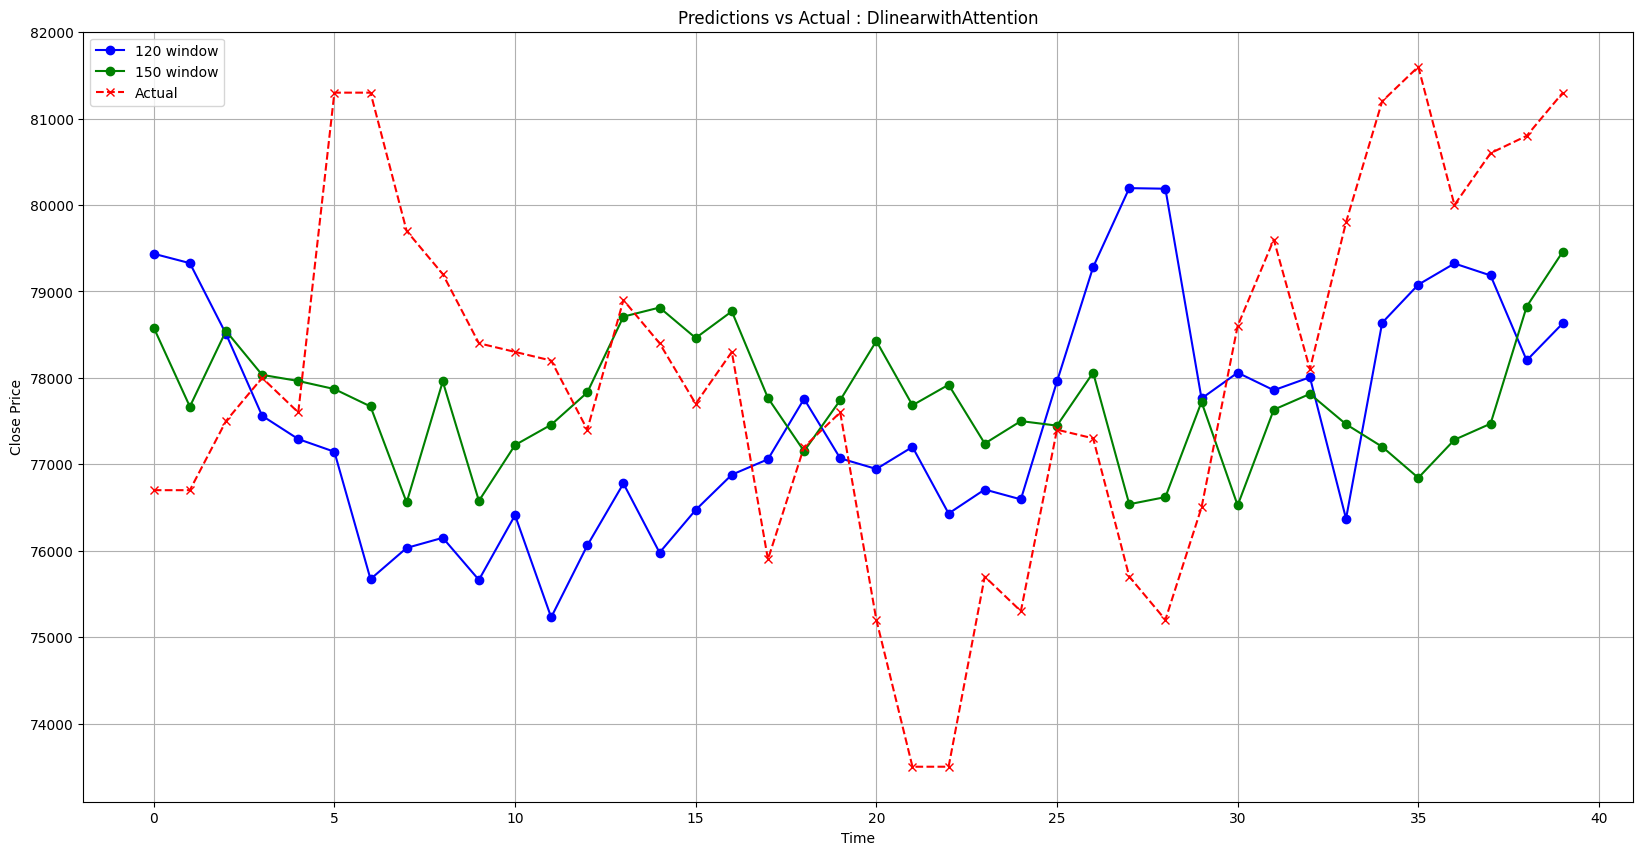

In [58]:
def plot_predictions(window_60, window_90, window_120, window_150, for_score_close, CFG):
    # 실제 값 추출
    for_score_close_last_10 = for_score_close[-CFG['PREDICT_SIZE']:]
    
    # 시각화
    plt.figure(figsize=(20, 10))  # 그래프의 크기 설정
    
    # 각 예측 값 시각화
    # plt.plot(window_60, marker='o', linestyle='-', color='b', label='60 window')
    # plt.plot(window_90, marker='o', linestyle='-', color='g', label='90 window')
    plt.plot(window_120, marker='o', linestyle='-', color='b', label='120 window')
    plt.plot(window_150, marker='o', linestyle='-', color='g', label='150 window')
    
    # 실제 값 시각화
    plt.plot(for_score_close_last_10.values, marker='x', linestyle='--', color='r', label='Actual')
    
    # 그래프의 제목 및 축 레이블 설정
    plt.title('Predictions vs Actual : DlinearwithAttention')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# 함수 호출 예시
plot_predictions(pred60, pred90, pred120, pred150, vaild['Close'], CFG)


# 60 window, 90 4 0.01 4 128 , 2498 
# 90 window, 90 4 0.01 4 128 , 2017.
# 120 window, 90 4 0.01 4 256, 2491 
# 150 window, 90 4 0.01 4 128  2168

[78652.72  73484.    73734.67  77244.08  78155.74  78729.83  76309.38
 78051.37  79503.28  76981.52  77411.39  76634.69  73710.12  75204.06
 76757.2   75745.53  74958.75  77393.055 76515.57  76007.88  75362.22
 78501.87  75448.94  74436.09  72670.92  72218.56  74295.83  74745.98
 75321.56  75207.625 76805.47  78656.31  79038.34  79809.89  80841.07
 77542.61  75720.38  77439.47  80312.03  79107.07 ]
90 4 0.01 4 128


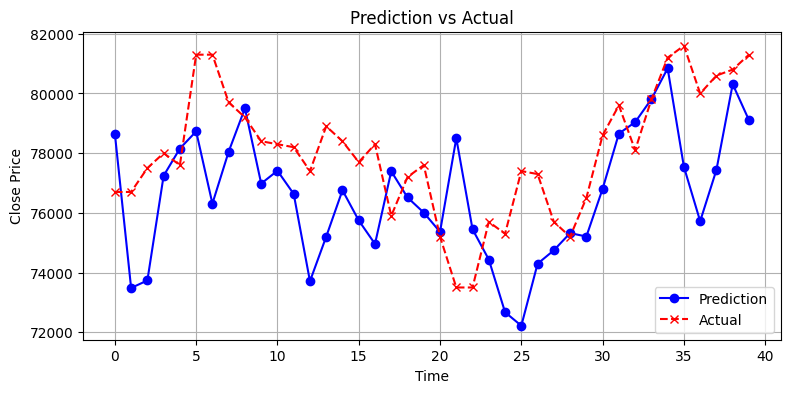

Root Mean Squared Error (RMSE): 2498.6608654993365
*************************************************************************************


In [52]:
pred60 = eval_model(90,4,0.01,4,128)
# pred90 = eval_model(90,4,0.01,4,128)
# pred120= eval_model(90,4,0.01,4,128)
# pred150= eval_model(90,4,0.01,4,128)

[78581.016 77667.016 78542.336 78034.39  77963.59  77870.16  77668.91
 76557.84  77957.99  76576.51  77222.19  77457.45  77831.    78708.53
 78813.38  78461.01  78769.22  77766.83  77151.2   77741.61  78425.55
 77682.5   77920.17  77239.67  77499.42  77446.83  78060.27  76537.63
 76620.07  77721.03  76523.945 77631.32  77813.81  77463.16  77202.33
 76842.734 77283.25  77469.164 78824.83  79460.62 ]
90 4 0.01 4 128


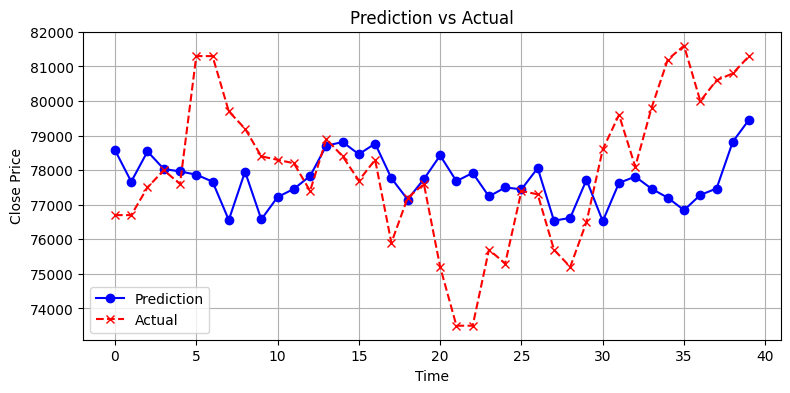

Root Mean Squared Error (RMSE): 2168.1647179391634
*************************************************************************************
[79735.195 78685.64  78116.43  77641.06  77824.984 79262.875 77601.125
 77521.336 75180.06  76301.17  77675.06  77885.58  78613.58  78721.
 77700.    79805.14  79424.125 81923.875 81145.72  79498.    78851.79
 78636.23  80065.64  80336.81  80209.56  79666.86  81182.664 79891.46
 81542.445 79800.516 78666.234 79242.44  79747.85  77924.41  77178.516
 78519.88  79161.016 79882.55  79555.836 80896.44 ]
90 4 0.01 4 256


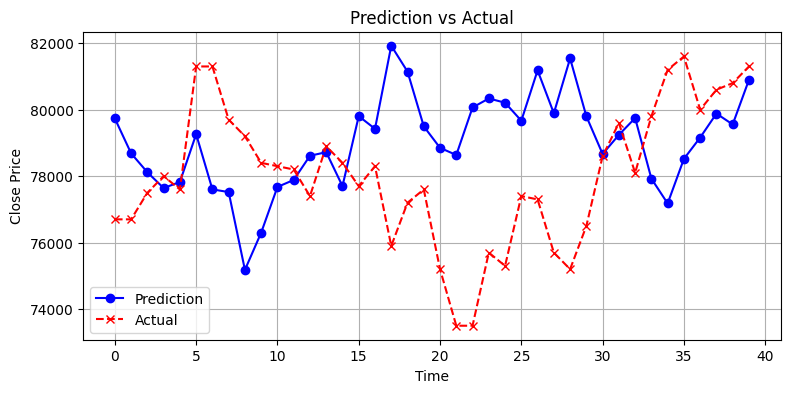

Root Mean Squared Error (RMSE): 3052.784575888568
*************************************************************************************
[82000.305 81930.91  81264.33  79660.56  80568.42  78076.01  76500.37
 77631.92  77204.45  75045.    75780.26  77266.05  80530.375 79681.016
 78020.31  79875.11  81528.95  80103.555 78863.41  79726.59  77337.45
 74555.61  75081.78  78295.875 79221.54  80473.36  79366.49  77892.62
 78015.41  78713.984 77231.5   76134.63  77466.19  77438.016 76973.81
 75896.14  73437.305 75342.7   75406.42  76840.47 ]
90 4 0.01 5 128


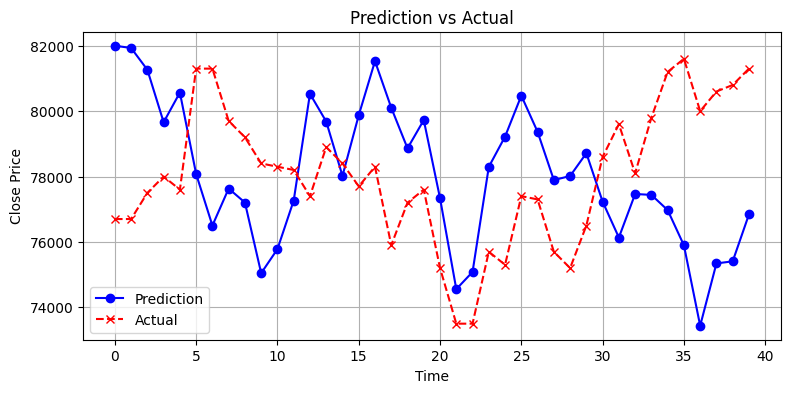

Root Mean Squared Error (RMSE): 3330.2730320641685
*************************************************************************************
[82369.08  81435.25  80663.78  79885.86  80806.55  81126.83  80025.87
 80817.47  79919.25  80799.16  80833.47  80457.875 80558.016 78009.17
 79339.586 78680.22  81211.03  79709.2   79710.66  80797.72  79884.02
 80674.55  80134.79  78887.94  80340.484 81381.56  81454.164 82747.84
 83483.14  80525.53  80833.84  81536.53  81764.766 82463.61  81722.55
 82691.84  78882.49  82754.97  81610.38  82145.24 ]
90 4 0.01 5 256


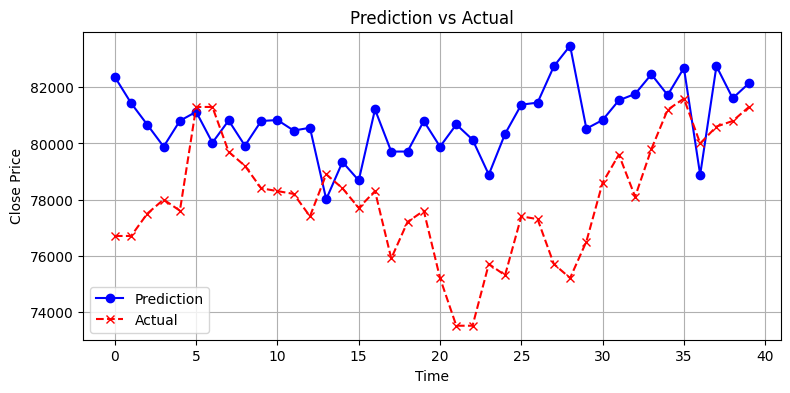

Root Mean Squared Error (RMSE): 3570.0841250426565
*************************************************************************************
[81450.41  80052.53  79417.484 80794.38  79824.17  79294.664 77777.94
 75257.3   74010.39  76189.31  75813.664 75918.41  78057.75  79340.984
 77610.8   78835.97  81760.05  79903.31  78647.74  78338.2   79364.61
 76498.39  77714.2   76913.59  76360.36  79397.086 78966.375 77843.94
 76652.02  77757.484 78593.52  76443.    79898.59  79372.88  76476.42
 74696.516 77046.36  80624.23  81019.95  81113.78 ]
90 4 0.01 8 128


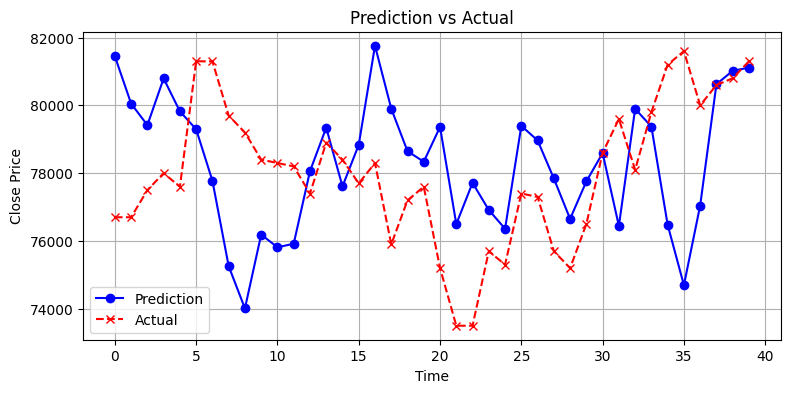

Root Mean Squared Error (RMSE): 2813.7726760621613
*************************************************************************************
[78465.484 80722.086 79856.38  81149.984 79406.58  79791.47  78534.55
 79690.375 79964.53  79637.49  79414.84  78090.33  80819.516 80666.195
 82093.44  82032.445 80113.125 80690.53  80339.375 80120.47  79342.64
 77675.41  81355.99  80434.21  80257.86  77677.72  77465.21  81379.91
 78651.78  79069.055 75099.72  77953.336 76037.15  79541.766 79867.875
 80018.28  79693.195 79282.875 80784.125 83906.16 ]
90 4 0.01 8 256


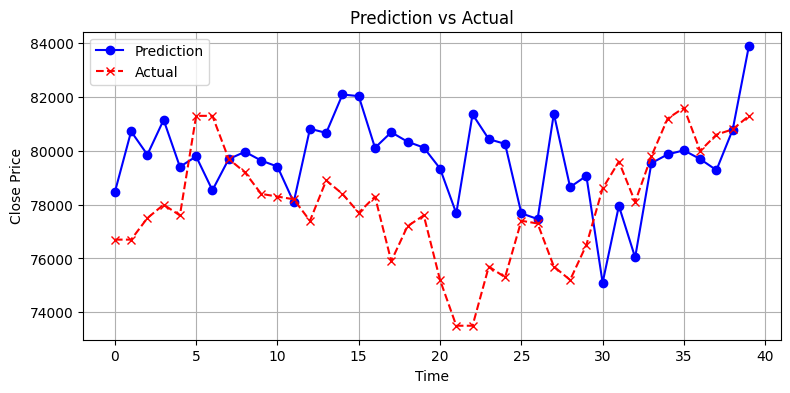

Root Mean Squared Error (RMSE): 3030.532889722683
*************************************************************************************
[78261.22  81162.266 81558.34  79956.555 79492.51  79126.75  78270.4
 79334.125 79896.31  78675.016 80310.984 80819.88  81786.98  80250.95
 80496.266 80033.11  79556.59  79967.125 79886.22  80554.29  78542.234
 79235.28  78742.516 81205.56  81191.25  78597.766 79203.39  77468.33
 79022.92  79253.3   77393.56  76842.375 77303.7   76985.17  74340.02
 76310.234 74176.67  76165.86  78558.484 77120.875]
90 4 0.05 4 128


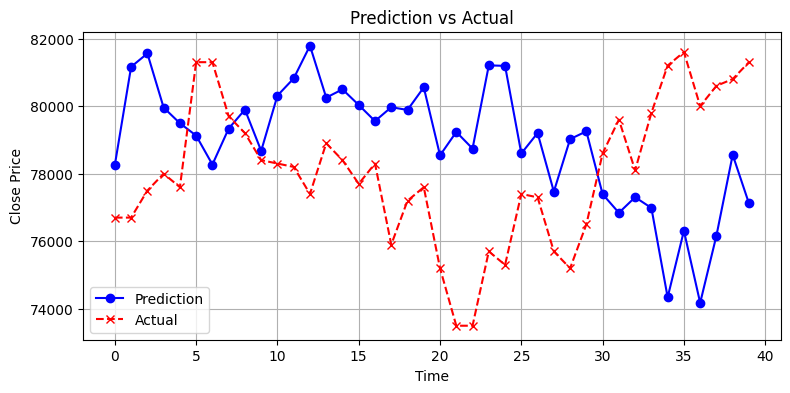

Root Mean Squared Error (RMSE): 3436.4647993884964
*************************************************************************************
[80275.59  81770.91  80604.8   80204.695 82557.    80900.91  79575.83
 81110.41  79428.42  79135.516 80844.164 80743.414 80078.97  81901.83
 80550.914 81691.47  82647.25  82188.05  82047.805 82010.1   83719.734
 82037.81  82166.88  82328.39  82643.65  82075.28  82648.03  83598.875
 80370.31  80656.91  81068.39  81604.97  80264.55  83734.25  82920.94
 82025.72  81991.5   82347.45  81536.08  82471.42 ]
90 4 0.05 4 256


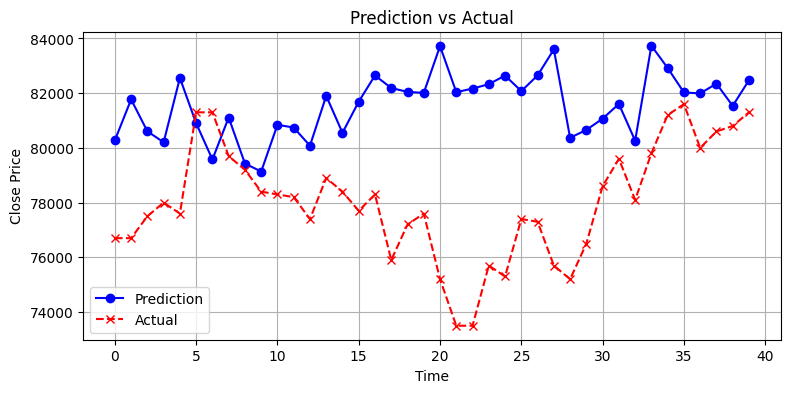

Root Mean Squared Error (RMSE): 4336.0076302894095
*************************************************************************************
[80548.67  80534.69  80362.305 79289.664 79291.62  78597.56  77883.18
 78079.09  76828.61  77276.81  79505.21  78755.77  78724.125 79796.55
 79072.1   80014.1   80127.5   80019.25  81129.78  80634.89  81925.22
 79687.54  79131.31  78674.79  79359.53  78190.51  80086.516 78893.93
 78590.83  79736.11  79411.16  79195.67  80175.984 79794.234 78927.984
 80515.94  80480.86  79739.45  79853.45  82088.23 ]
90 4 0.05 5 128


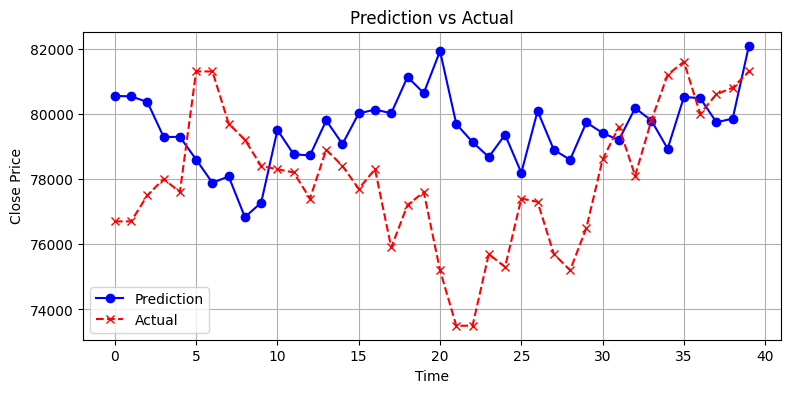

Root Mean Squared Error (RMSE): 2832.337040794071
*************************************************************************************
[79407.81  79662.96  79523.336 78685.41  79096.27  79101.34  78059.66
 76855.21  78502.91  78206.98  77875.36  78215.766 77629.81  76960.55
 76754.    76712.58  76749.31  77429.56  77119.66  77690.03  76621.01
 77407.71  77080.08  77768.19  77772.94  77706.22  77069.17  77897.34
 77248.55  76779.234 78093.73  77914.36  78274.46  79114.53  79217.54
 78999.47  78134.94  79234.21  79174.36  78848.67 ]
90 4 0.05 5 256


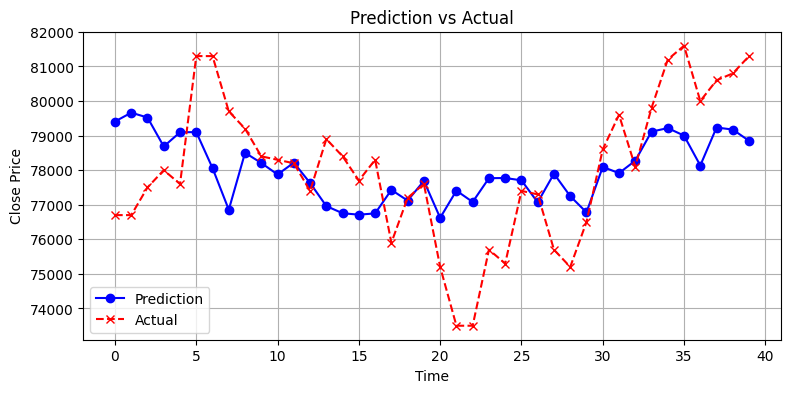

Root Mean Squared Error (RMSE): 1852.9528209656469
*************************************************************************************
[78752.984 81034.78  78543.64  80717.74  77682.29  78815.22  78085.06
 77083.22  78001.516 79991.74  79951.38  79580.86  79680.65  80056.195
 79413.02  78398.375 80654.81  80299.266 80063.17  79148.53  77234.695
 77655.67  78595.03  78060.41  76225.41  78327.09  76866.305 75644.06
 77050.24  80167.64  79023.445 78836.6   79037.266 80283.99  79691.08
 78084.16  77647.42  77019.47  80844.016 80532.53 ]
90 4 0.05 8 128


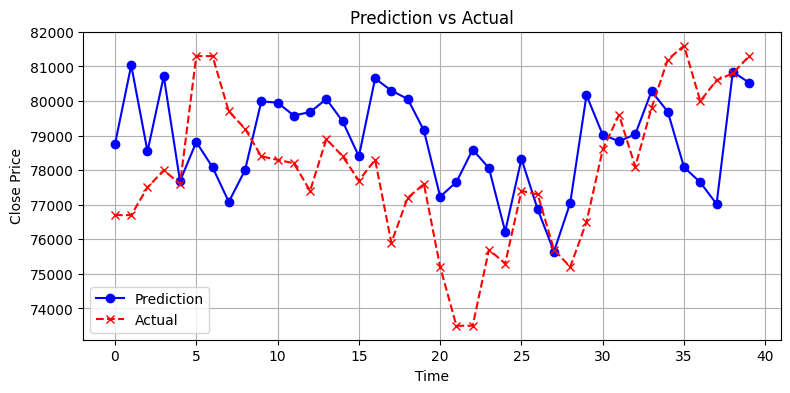

Root Mean Squared Error (RMSE): 2313.9581273717545
*************************************************************************************
[81474.72  82113.66  81288.57  80238.56  80345.72  79927.    80113.234
 79856.45  79952.875 79151.41  79936.69  81097.516 80962.42  81260.016
 81706.39  80155.69  80355.305 81160.234 80857.71  81032.    81377.58
 81675.37  81763.69  81459.266 81075.11  81030.83  80910.12  81359.04
 82286.06  82885.19  81177.2   81020.016 81650.836 80712.81  81190.54
 80288.97  82025.14  82175.47  82486.2   82824.64 ]
90 4 0.05 8 256


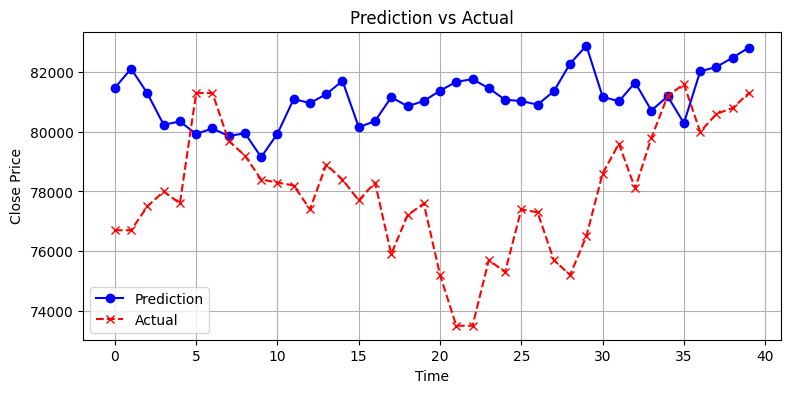

Root Mean Squared Error (RMSE): 3909.6355025569846
*************************************************************************************
[77694.305 76176.96  74483.68  75759.9   74086.25  76206.88  76028.39
 77870.63  77181.86  75089.8   78462.125 77001.83  73994.59  75014.05
 76257.445 74586.016 77753.91  76168.19  76671.67  78393.125 79255.03
 77895.56  76868.42  80770.28  78661.25  77153.5   77371.55  77254.56
 76254.21  78725.66  75614.97  77834.23  76813.34  74544.805 75000.72
 77109.4   76631.86  76803.34  78275.44  74229.45 ]
90 6 0.01 4 128


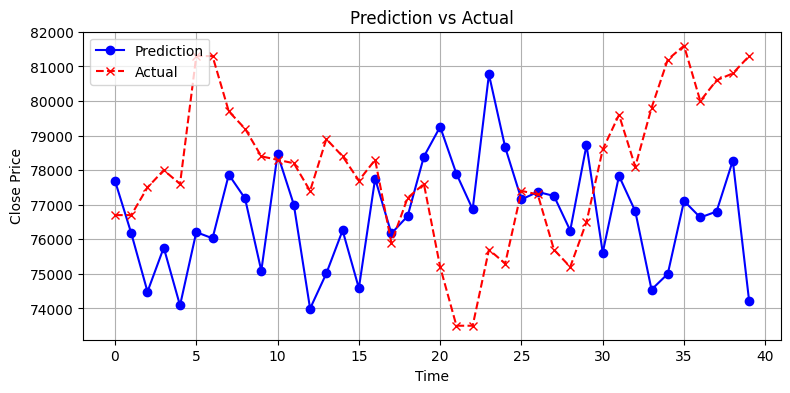

Root Mean Squared Error (RMSE): 3233.5849496925784
*************************************************************************************
[80433.484 79235.01  80904.25  80536.5   79430.05  79357.06  80213.05
 78392.984 79161.5   79483.58  79949.5   78820.2   78596.24  76349.34
 78775.06  78341.56  79303.56  79652.86  78716.58  80407.53  80249.305
 80766.47  80250.28  81882.8   81755.016 79841.41  78652.16  79855.586
 80841.43  80866.    79829.31  78616.39  77386.984 79223.195 78217.81
 78586.805 80534.94  80485.2   80193.016 78498.67 ]
90 6 0.01 4 256


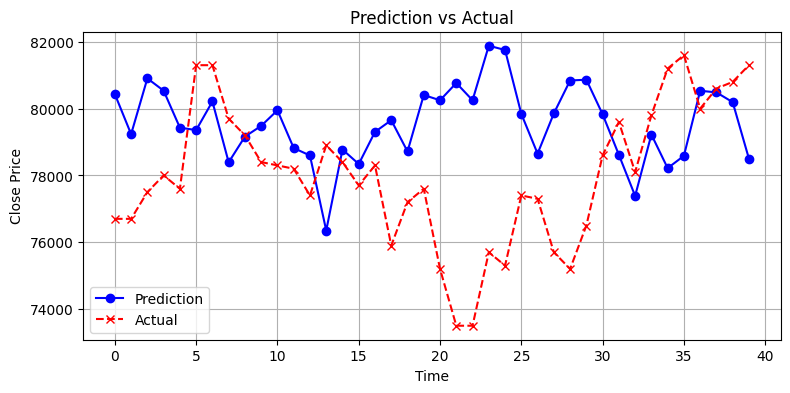

Root Mean Squared Error (RMSE): 3146.25186922499
*************************************************************************************
[79898.02  81047.53  79511.07  79631.27  79063.47  78490.7   78351.08
 78662.164 79367.445 78449.41  78644.55  76847.086 77057.27  78350.414
 76870.55  75338.26  78604.83  76981.67  77921.15  80380.14  79130.67
 78404.66  80902.34  79433.234 78205.39  77199.09  77942.766 78040.41
 79973.45  80230.53  79310.67  79839.47  78906.64  78826.17  75748.05
 76911.83  76627.36  77764.8   76465.8   77298.33 ]
90 6 0.01 5 128


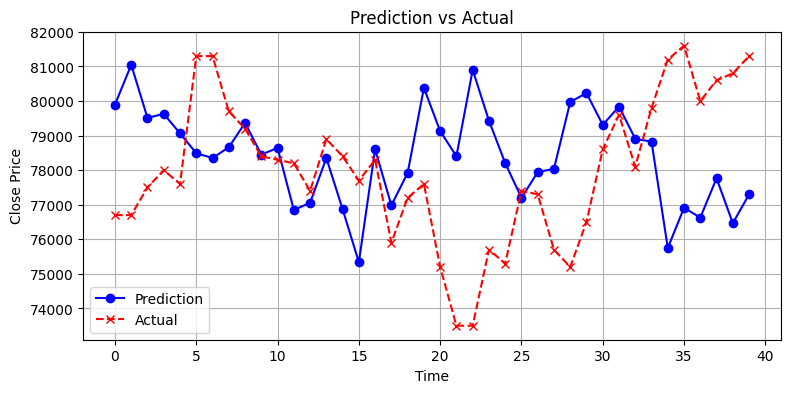

Root Mean Squared Error (RMSE): 2927.703009294022
*************************************************************************************
[78640.72  78931.92  82062.484 78371.56  79084.28  78311.3   79033.984
 79122.08  79568.62  78881.72  77545.29  76475.75  75573.44  76492.09
 75897.47  80724.38  81333.234 78676.09  79649.516 80134.19  78320.484
 77978.984 80652.086 80470.78  78714.84  77439.6   75906.47  81120.55
 80017.09  81151.86  77890.14  78795.26  76930.53  77020.53  71223.625
 74294.77  77894.19  76466.72  75265.78  77225.53 ]
90 6 0.01 5 256


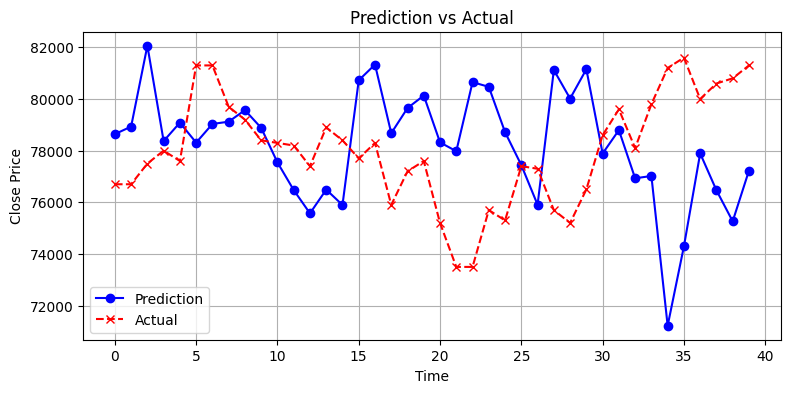

Root Mean Squared Error (RMSE): 3631.526067114723
*************************************************************************************
[81397.5   81763.47  82900.45  81414.83  80873.81  81276.42  80128.875
 78869.03  78932.19  78770.97  78329.16  78966.984 80245.89  77862.61
 81195.14  80157.03  79609.35  79718.06  80075.586 80895.36  79797.4
 80404.016 79104.78  80162.36  80557.41  79900.06  80630.27  80151.04
 80351.05  79884.086 79587.484 79975.62  78697.39  78654.51  78726.
 78582.55  77099.84  77552.66  77094.1   77623.5  ]
90 6 0.01 8 128


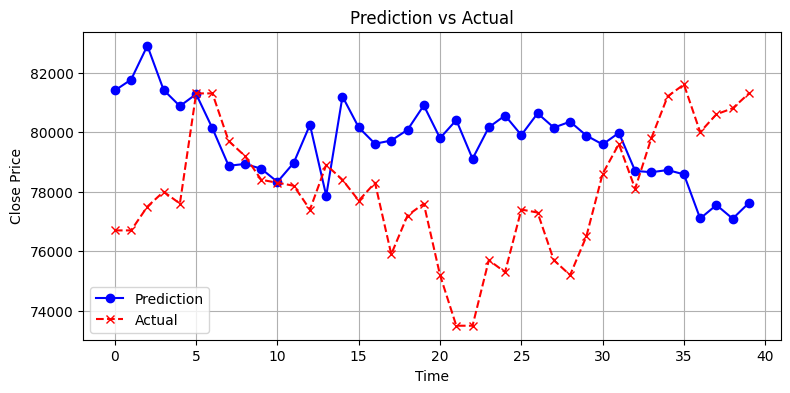

Root Mean Squared Error (RMSE): 3340.73415194384
*************************************************************************************
[76899.28  78566.25  77315.92  77598.69  79162.    77156.33  77162.67
 76681.43  74575.07  75302.28  77063.91  76070.484 72973.58  76276.61
 76306.    76713.92  76044.25  75164.96  77476.08  76435.016 77159.87
 75979.95  76900.46  76080.78  76962.96  74438.17  74281.16  74988.99
 75444.164 76623.516 76977.55  76946.59  78161.375 76585.67  77042.14
 76303.234 76017.61  76372.83  76269.14  76275.5  ]
90 6 0.01 8 256


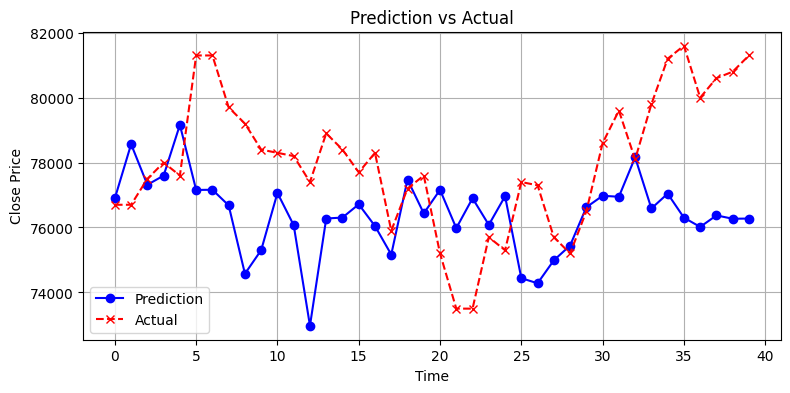

Root Mean Squared Error (RMSE): 2798.5969800193607
*************************************************************************************
[78204.266 79495.05  79031.68  77267.69  77979.14  78873.2   79920.8
 79226.05  78530.72  78610.44  78120.06  76937.67  75412.39  75922.12
 76358.2   74037.25  75915.61  76107.18  75736.86  76291.09  75527.03
 75823.484 75453.25  76004.31  75663.57  75141.44  76357.93  75712.734
 73355.695 74736.15  75014.97  75349.95  75376.016 76288.28  74913.67
 76992.32  73216.3   75767.2   76237.14  75816.8  ]
90 6 0.05 4 128


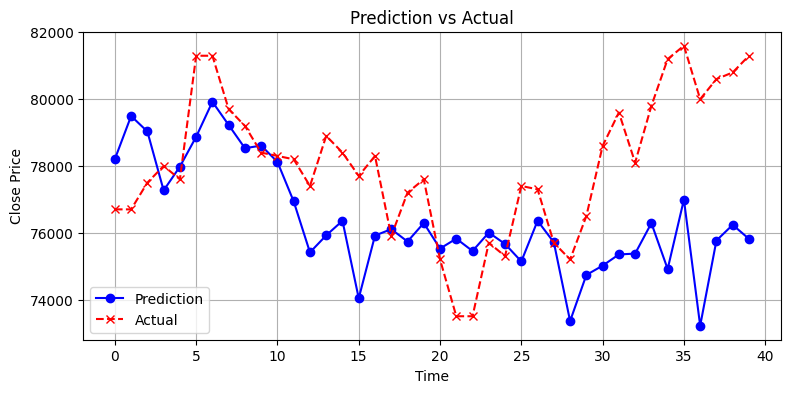

Root Mean Squared Error (RMSE): 2814.8873154804155
*************************************************************************************
[78989.56  79495.38  79633.31  79643.414 78616.91  79341.45  79029.63
 77097.14  76685.76  76179.375 76611.19  77391.984 77562.26  78141.516
 77808.8   77585.32  76707.07  77216.33  77655.68  78157.84  77530.61
 78215.73  77476.13  78035.66  78048.65  78235.75  77498.86  77296.32
 77045.07  75584.2   76027.484 75500.164 74436.5   74229.266 74859.586
 74707.625 74851.805 76844.125 75735.695 76481.8  ]
90 6 0.05 4 256


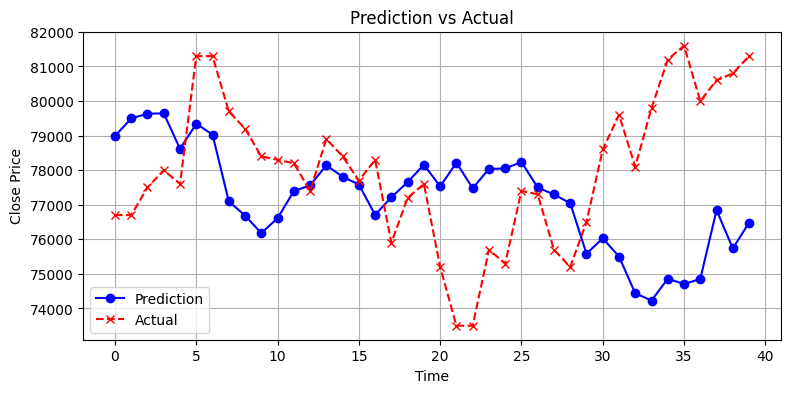

Root Mean Squared Error (RMSE): 3027.774292028037
*************************************************************************************
[79964.516 78285.5   78186.016 77064.7   77109.625 78408.42  77728.21
 77732.484 79111.98  78601.01  78839.95  77729.89  77398.06  77408.56
 77786.016 76947.9   77467.17  76178.92  77004.5   76934.72  76881.914
 76423.79  77311.33  75722.445 75240.07  75643.7   75526.34  76403.92
 77048.31  76714.81  76108.68  75473.82  76294.03  76841.96  75423.234
 77099.    77023.56  76643.39  77622.91  77434.516]
90 6 0.05 5 128


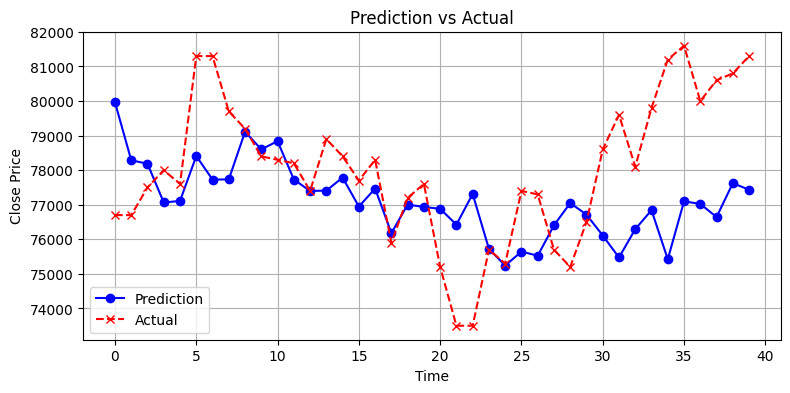

Root Mean Squared Error (RMSE): 2341.1864059373584
*************************************************************************************
[84571.2   84473.766 84612.97  83325.06  82836.09  78458.26  78650.72
 79049.945 78149.17  77452.125 76927.125 78140.81  77305.914 75031.15
 76320.39  76980.58  76205.45  75972.484 76993.22  76694.086 76284.85
 77292.56  76711.875 75211.766 75832.98  74648.11  76579.75  78203.11
 76689.89  75568.92  73083.445 75381.875 75093.8   73600.875 75209.03
 75331.01  74453.734 74048.85  76333.8   75642.86 ]
90 6 0.05 5 256


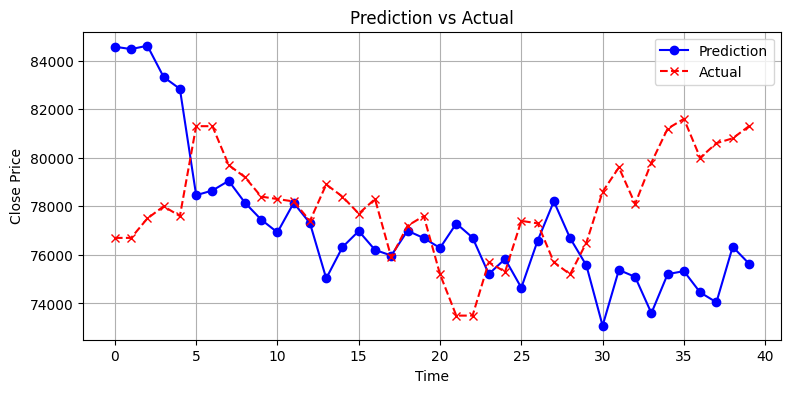

Root Mean Squared Error (RMSE): 3916.60697411212
*************************************************************************************
[79316.92  81732.69  82550.44  81804.016 80977.12  78913.14  80137.67
 80500.34  79951.45  78860.17  80693.64  79009.55  80293.83  80260.09
 79631.5   80653.42  79588.52  81762.734 80921.84  81554.266 79253.984
 81630.55  79468.52  80092.41  80337.14  81325.44  81251.836 80616.84
 81761.92  81041.53  79117.11  79254.58  80560.38  81328.81  80508.84
 80233.53  80922.97  80330.914 80446.68  80673.414]
90 6 0.05 8 128


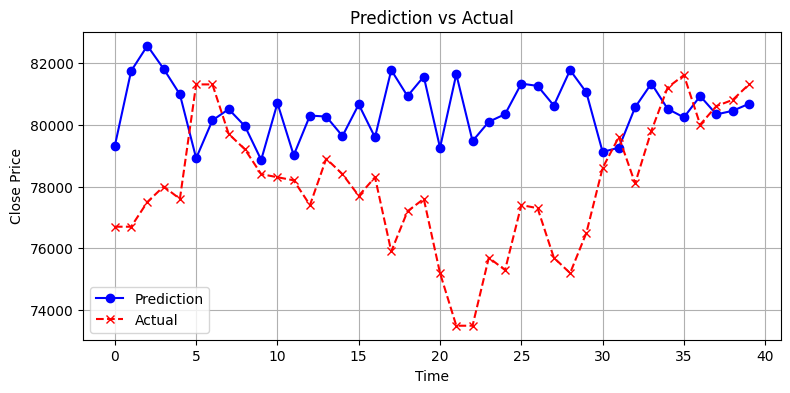

Root Mean Squared Error (RMSE): 3459.306256651343
*************************************************************************************
[78591.    79637.484 80074.78  79169.86  80663.43  79686.44  77738.16
 77217.17  76356.7   78870.56  77265.86  77382.24  77322.22  76574.86
 77361.89  78091.66  77831.82  77154.42  76608.805 77119.74  77742.91
 79398.53  78153.94  78539.44  77316.01  77730.625 78763.49  78994.945
 79245.68  79432.195 78809.37  79462.49  79605.58  79541.09  79592.73
 78926.31  76146.31  77426.805 77304.21  78211.02 ]
90 6 0.05 8 256


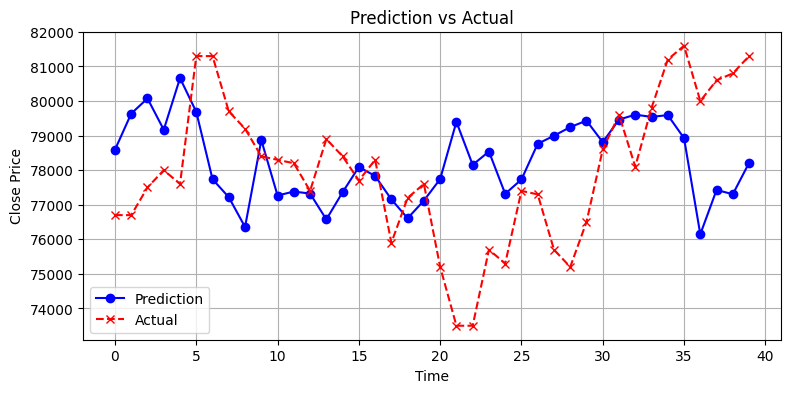

Root Mean Squared Error (RMSE): 2459.833304669541
*************************************************************************************
[78724.44  79965.36  81445.125 82504.41  82931.414 81538.08  79089.94
 79165.87  79982.73  78955.33  79248.83  78490.97  79456.54  79753.69
 78229.46  77776.94  79782.22  79868.69  79549.22  79240.07  79418.91
 79690.72  78921.64  78924.16  79196.09  77198.734 79443.45  79552.66
 78034.7   78727.42  78427.51  78627.92  79786.42  79733.17  77760.47
 78489.805 76957.164 77700.43  79641.35  80488.06 ]
90 8 0.01 4 128


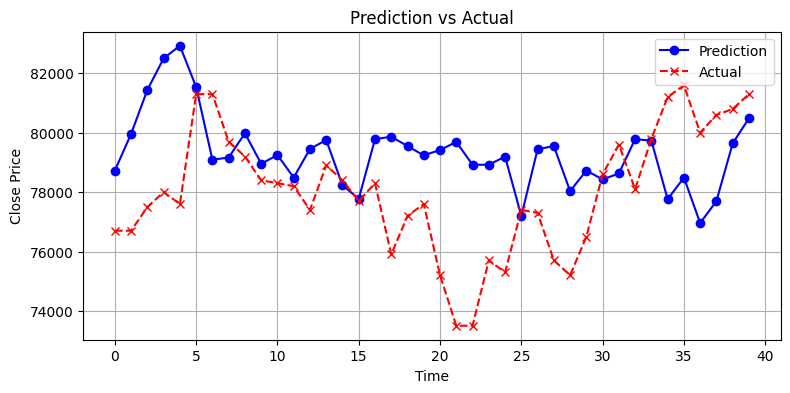

Root Mean Squared Error (RMSE): 2765.334527858959
*************************************************************************************
[76974.3   77989.43  76155.55  75312.7   76140.67  76099.05  76907.42
 77770.94  76493.77  76327.68  77247.09  77331.39  76994.83  77293.625
 77392.6   76906.72  77175.016 78207.586 78050.67  77537.39  78061.36
 77491.24  77366.984 78127.17  77158.15  77728.93  77445.76  77226.125
 77746.61  77191.41  75678.234 75468.69  75345.72  76934.45  76339.74
 76639.234 75855.06  75766.43  76264.73  77839.97 ]
90 8 0.01 4 256


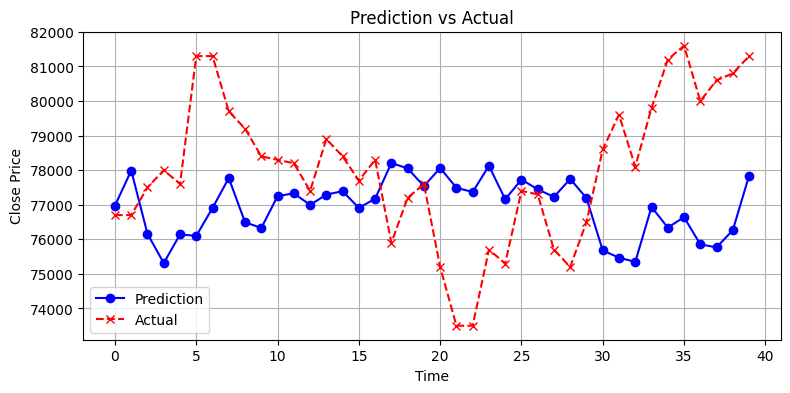

Root Mean Squared Error (RMSE): 2778.0609201857737
*************************************************************************************
[77666.586 78489.75  78596.34  77791.984 78415.875 77717.95  76286.016
 77714.08  76246.69  78165.516 76979.22  76904.75  77656.125 76648.14
 77043.2   76047.5   77397.22  77966.84  77771.375 77946.25  77496.41
 75774.22  75103.47  75032.05  77120.61  76514.914 76812.3   75025.64
 74697.06  75817.83  76379.28  77507.74  76644.66  76510.31  76783.16
 78446.88  75302.83  77519.63  76700.56  78159.11 ]
90 8 0.01 5 128


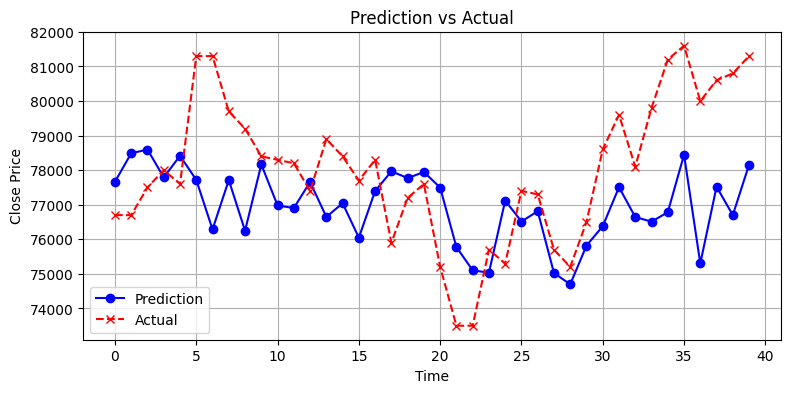

Root Mean Squared Error (RMSE): 2259.9676595770766
*************************************************************************************
[80900.914 81077.22  79078.01  80808.016 80782.14  79474.36  78856.41
 77253.83  76913.89  76361.33  78491.3   78657.36  80958.95  79962.33
 80589.44  79233.2   78610.12  78327.36  80398.5   79429.16  81097.11
 79615.8   79213.73  80210.55  78847.84  81860.66  85210.44  81853.78
 80628.59  78622.97  80335.51  81547.125 81327.3   80119.44  79485.2
 81761.695 78625.36  80050.94  82429.75  81736.91 ]
90 8 0.01 5 256


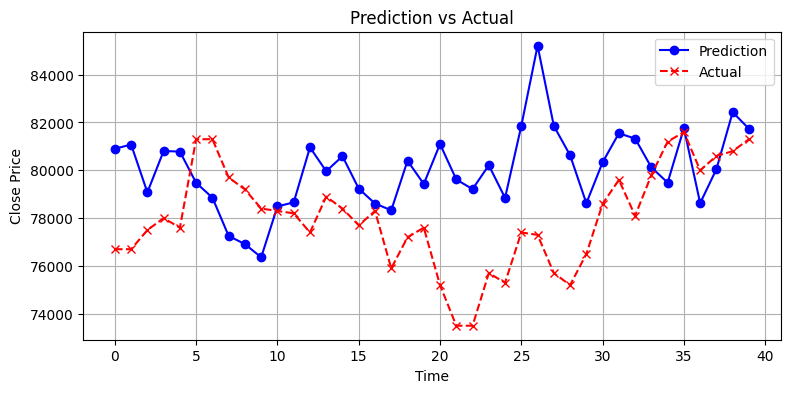

Root Mean Squared Error (RMSE): 3317.114102884398
*************************************************************************************
[79486.25  79039.77  77383.53  74251.16  81598.95  80770.69  77958.68
 77258.03  78390.44  79788.19  79233.89  78872.64  81192.28  80901.42
 80344.26  79804.695 81624.14  78398.22  81120.32  81543.41  81245.27
 79600.914 80446.    80950.53  79501.055 79616.42  80787.97  79654.94
 79927.91  80103.28  80008.82  80349.41  80809.81  78955.36  78216.25
 75167.79  77653.81  79383.07  77616.92  80600.12 ]
90 8 0.01 8 128


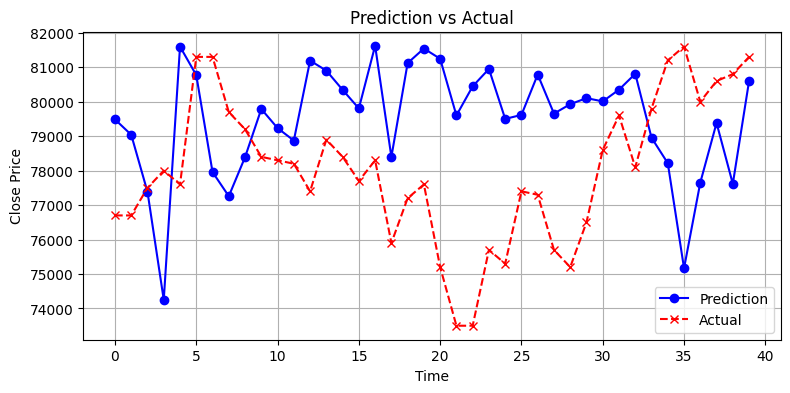

Root Mean Squared Error (RMSE): 3365.9780300708558
*************************************************************************************
[79034.195 81341.75  79561.516 80387.734 79415.09  79765.8   81024.25
 79047.56  78795.83  79592.31  77873.42  80883.18  80071.97  80771.234
 80071.766 80227.445 80718.76  82553.59  84922.31  81799.67  80103.95
 80395.59  84471.305 82186.79  80637.46  80943.49  82244.39  81288.5
 83435.45  81449.33  82732.875 81912.54  80831.39  80225.55  81375.41
 83776.67  83744.82  85293.39  84250.33  84277.984]
90 8 0.01 8 256


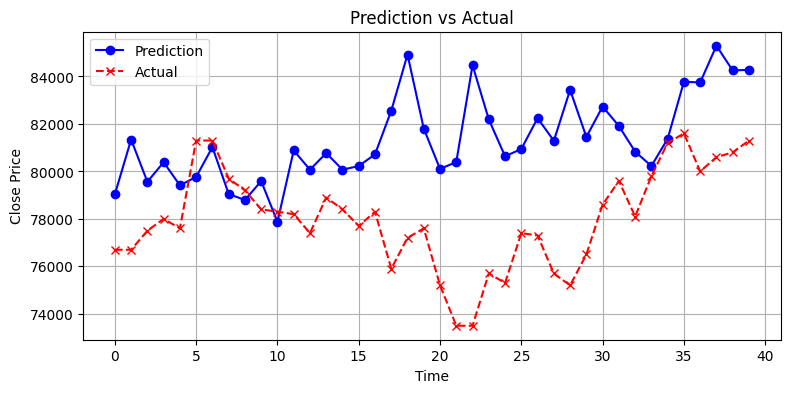

Root Mean Squared Error (RMSE): 4225.011131797076
*************************************************************************************
[78048.57  78019.414 79808.14  79227.54  80312.42  78430.94  77152.95
 76476.33  76317.016 77329.516 77343.19  78133.99  77406.41  79060.89
 77421.91  78428.266 80916.95  78734.97  77215.85  75847.17  76822.01
 77617.08  78494.28  77339.66  79175.14  78841.8   78638.03  78086.25
 80143.74  79781.92  78184.11  79091.86  79801.94  78820.3   80114.86
 80541.87  78217.53  81082.11  81197.42  81538.42 ]
90 8 0.05 4 128


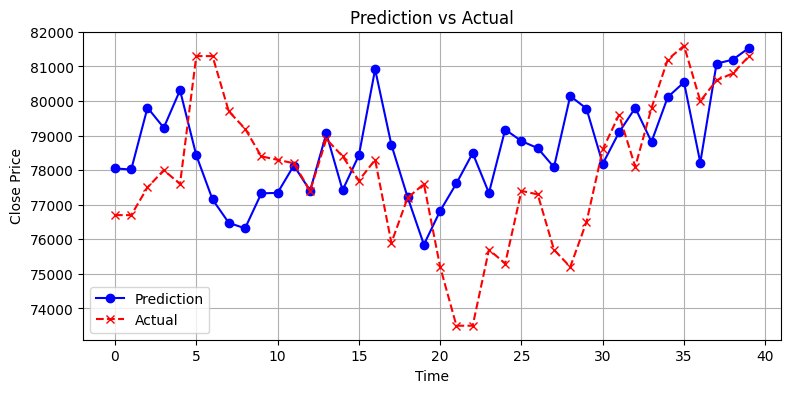

Root Mean Squared Error (RMSE): 2239.6121608193444
*************************************************************************************
[78227.516 79915.266 77560.78  75784.39  76116.53  75192.3   75057.42
 76650.81  76935.06  75912.33  77769.71  76210.55  75452.91  77284.21
 76907.    76273.484 77046.234 77624.38  77842.234 78502.09  76861.484
 76818.055 76171.19  76548.67  78257.8   77277.484 77630.5   78123.71
 76466.14  78367.14  77170.75  77502.69  77663.67  78801.984 77508.92
 77241.375 76673.234 76309.47  75777.02  77481.24 ]
90 8 0.05 4 256


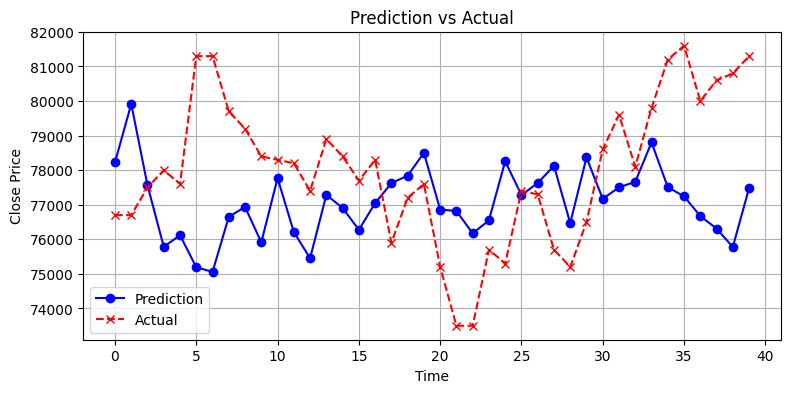

Root Mean Squared Error (RMSE): 2684.9203522380776
*************************************************************************************
[76744.64  76345.81  75913.42  76224.914 75022.93  75728.78  74942.05
 75026.02  75531.42  75234.375 75470.05  75279.875 75050.875 76466.016
 76224.234 75761.77  75500.18  75559.45  75501.516 75428.51  75535.87
 74641.875 75446.56  75599.19  74114.97  75253.61  75300.09  74167.78
 72983.44  72522.37  71775.25  73122.234 73986.61  73308.84  74003.09
 74426.89  73908.89  74793.34  74440.5   75923.266]
90 8 0.05 5 128


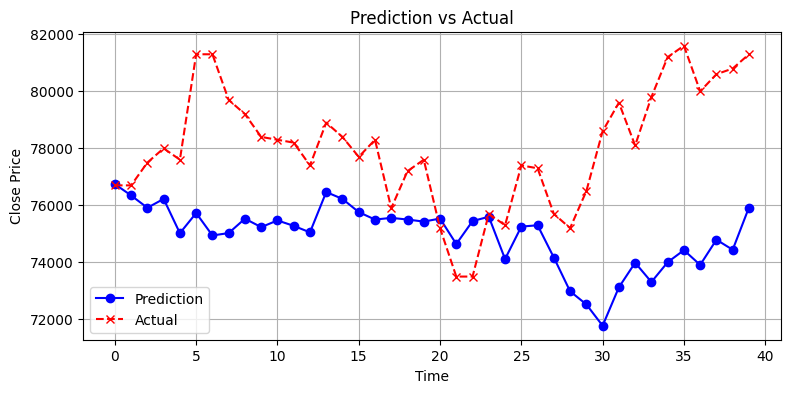

Root Mean Squared Error (RMSE): 3906.95635363548
*************************************************************************************
[82171.22  82020.75  79919.05  79984.26  80098.72  81224.82  80629.51
 79852.72  79189.61  78873.58  77956.09  77869.02  76506.14  76121.625
 76454.734 76988.47  77926.72  77763.91  78832.66  77887.17  78371.195
 77499.44  77490.83  76466.89  77008.45  78475.695 77605.58  77939.664
 75352.53  76557.44  75168.19  78331.31  79713.8   80052.94  77705.984
 78747.6   78523.875 79389.75  78201.72  79470.86 ]
90 8 0.05 5 256


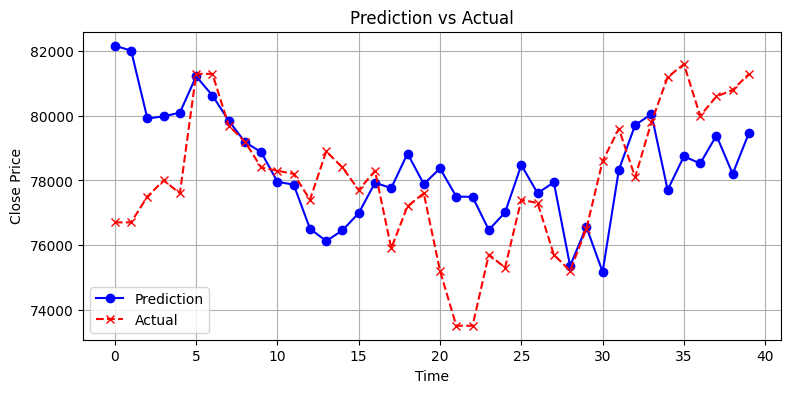

Root Mean Squared Error (RMSE): 2215.270958321017
*************************************************************************************
[81369.47  79906.74  80731.79  80207.56  81969.984 80738.12  80996.086
 78808.586 80180.97  79430.49  80114.766 80548.914 78668.266 78881.53
 79870.11  78208.195 81096.75  80511.61  79419.58  79291.81  77455.7
 77844.125 77895.75  79226.484 77706.13  78532.17  76484.61  77758.58
 77769.62  78854.84  77219.82  76213.016 76037.89  77477.44  76935.31
 76767.67  77042.766 80459.336 80280.74  80596.08 ]
90 8 0.05 8 128


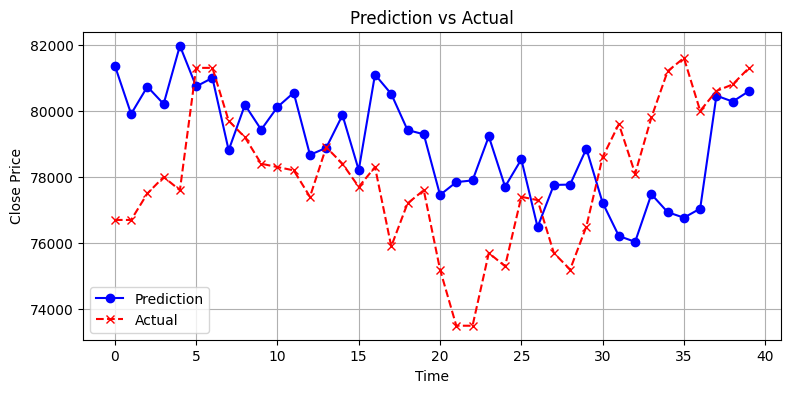

Root Mean Squared Error (RMSE): 2614.277660294532
*************************************************************************************
[80446.96  81365.266 80351.164 79363.28  79977.734 79538.17  78788.86
 78822.98  78505.86  78501.05  78655.17  78456.65  78751.02  77594.84
 78441.06  77836.28  78855.17  79291.695 78630.36  79583.14  79100.34
 78634.234 79686.64  79572.3   78874.42  80383.3   80156.33  79700.88
 79525.63  79801.26  78941.7   79077.875 79458.56  78567.945 78853.39
 78568.21  78129.266 79445.33  79959.05  79222.06 ]
90 8 0.05 8 256


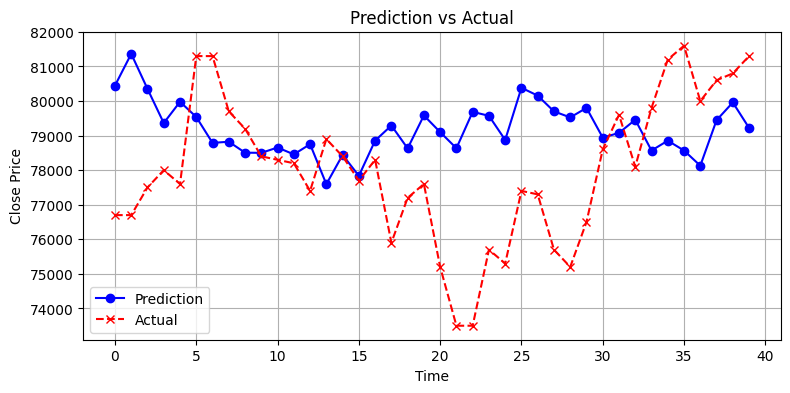

Root Mean Squared Error (RMSE): 2656.3674150333227
*************************************************************************************
[82889.97  83090.44  81608.16  81535.86  80360.28  84137.08  79105.61
 80605.586 81147.25  79691.555 77983.51  78079.71  75440.38  77501.88
 76809.516 79162.23  81304.17  77019.93  75201.97  79408.41  78437.08
 81401.45  79524.73  78312.39  78947.53  80694.92  79195.375 78917.11
 78614.3   78783.5   78903.97  80653.61  79192.625 79704.06  78657.86
 77306.86  78111.016 77951.37  74577.19  78221.766]
128 4 0.01 4 128


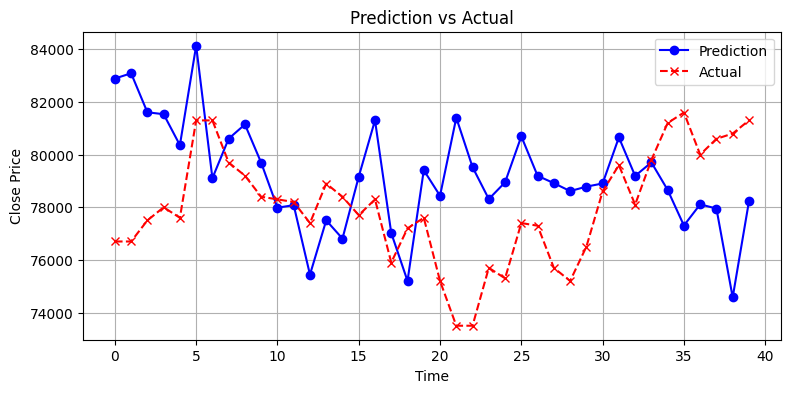

Root Mean Squared Error (RMSE): 3242.3186061580222
*************************************************************************************
[78547.1   77067.61  76514.69  77205.766 78690.28  76276.766 77818.44
 77796.14  77238.69  79686.73  77519.34  79100.76  80769.875 77492.625
 78373.375 77710.69  76911.55  78202.61  79400.09  78829.    75893.2
 77279.4   81258.75  79277.5   76321.83  76424.016 78360.89  78067.95
 77606.22  79509.125 78375.164 78800.38  79102.34  76805.    77694.266
 77494.61  76213.64  76829.234 77770.09  79469.016]
128 4 0.01 4 256


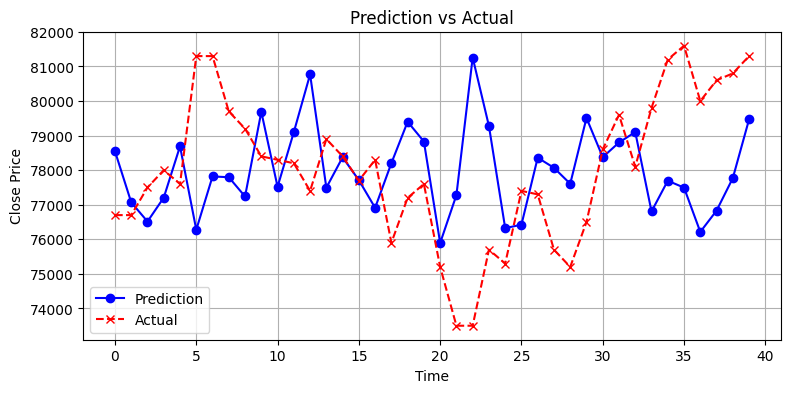

Root Mean Squared Error (RMSE): 2614.3347471303478
*************************************************************************************
[77817.45  82489.38  81594.7   80312.09  79587.8   81384.89  79752.484
 79846.43  78207.734 78836.2   79236.06  77002.516 77326.45  80380.95
 79751.14  80839.1   80278.93  80985.68  80399.41  84190.02  85176.914
 82414.93  81542.81  81340.04  81502.375 80462.78  81157.    79688.92
 78320.734 81757.086 81753.7   82603.836 81982.97  83557.45  80586.4
 79354.055 75714.42  78670.89  78338.47  80776.59 ]
128 4 0.01 5 128


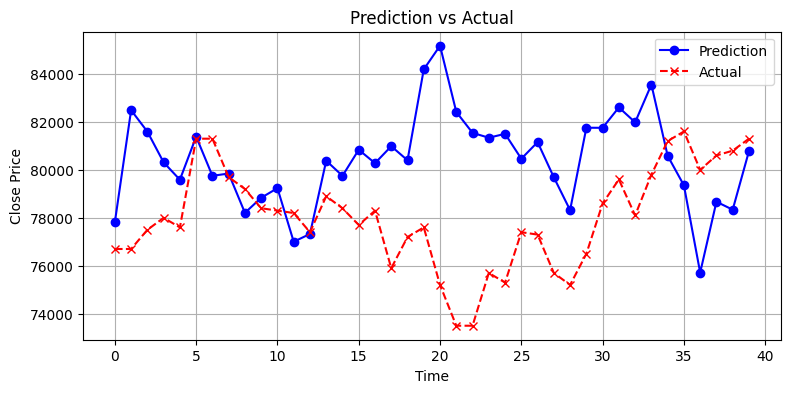

Root Mean Squared Error (RMSE): 3992.4705768692966
*************************************************************************************
[79490.875 77872.34  78886.484 78451.42  78966.734 77459.6   75886.69
 76890.766 76780.24  77104.88  76576.65  74819.39  75228.5   76665.09
 75756.72  75605.016 76604.59  78524.99  77476.45  78766.71  78089.74
 78531.2   76992.17  75729.59  76581.42  78348.875 78226.336 76595.57
 77183.94  76330.53  76250.16  74131.625 75692.766 76443.664 76439.64
 73980.14  75765.164 76158.45  78211.11  79047.34 ]
128 4 0.01 5 256


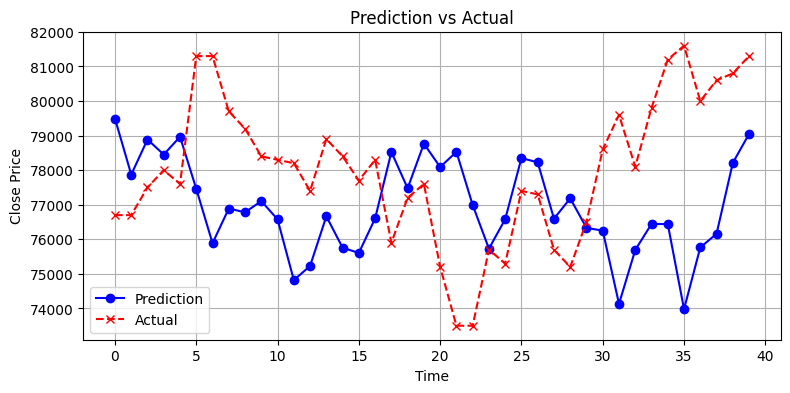

Root Mean Squared Error (RMSE): 2983.264081618445
*************************************************************************************
[78641.516 77994.31  76900.72  75877.78  74736.3   74685.53  75851.91
 77535.16  76834.19  76437.766 76102.31  77024.57  75412.8   75819.53
 74861.78  74185.984 76198.45  75353.13  76680.734 75967.28  76375.555
 80279.41  78411.625 78081.914 76053.22  76471.2   78088.64  77791.19
 78468.31  77578.875 77403.83  77974.016 77716.37  79408.3   78401.94
 78194.16  76714.65  78894.77  78505.12  77603.81 ]
128 4 0.01 8 128


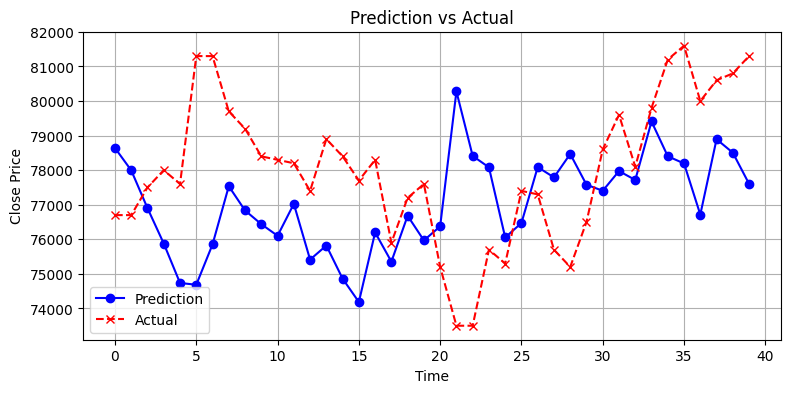

Root Mean Squared Error (RMSE): 2784.2767965417415
*************************************************************************************
[79295.08  79189.16  78551.17  78068.125 77930.016 80278.16  78170.25
 79339.766 79008.19  77436.266 77619.64  76788.03  78244.84  76992.055
 76991.33  78721.984 80195.41  79212.61  78175.8   77053.14  77527.36
 77142.03  79315.53  78174.81  78169.55  77846.84  78787.48  79115.945
 79011.49  79238.72  78375.69  79819.15  77555.66  78847.3   79287.41
 79000.27  78571.734 79135.91  79357.7   80378.875]
128 4 0.01 8 256


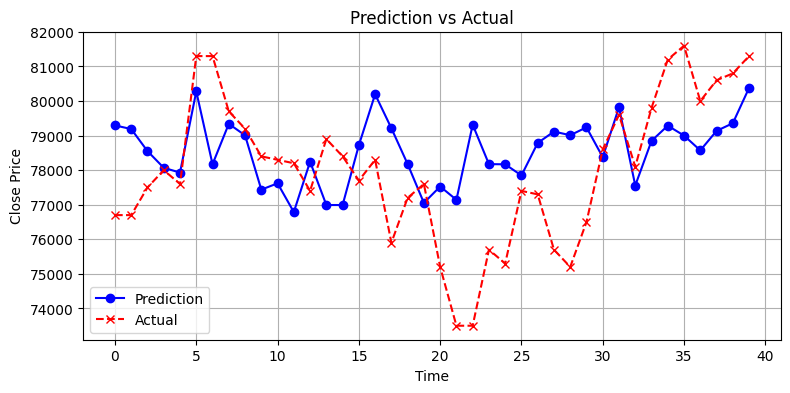

Root Mean Squared Error (RMSE): 2082.910914544027
*************************************************************************************
[81329.19  80873.97  80317.836 81462.016 79994.64  80136.03  79626.67
 79293.42  79349.67  79078.625 78612.66  80200.34  78046.29  80670.36
 78527.016 78353.66  79076.14  79512.28  81165.61  81804.72  80532.95
 80350.54  80573.57  81429.95  83000.34  83513.53  81260.59  80753.734
 78108.17  77695.914 78126.47  77342.57  77727.84  80317.44  78562.51
 77617.44  76182.53  77772.55  79818.69  77277.33 ]
128 4 0.05 4 128


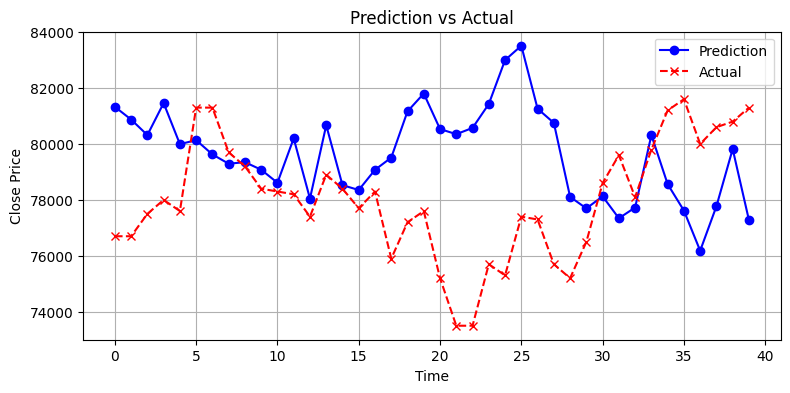

Root Mean Squared Error (RMSE): 3531.092143682664
*************************************************************************************
[78116.5   77507.95  77517.46  77772.484 78403.7   77640.34  78336.78
 77701.484 77165.34  78028.14  77805.39  78648.83  78903.39  78751.75
 78292.7   78708.89  79170.57  78256.11  77894.27  78782.95  79304.73
 77944.375 77810.875 78829.46  79218.43  78002.05  79165.67  77796.234
 77792.984 77282.96  77352.56  75974.65  77549.266 77814.484 78115.11
 77429.39  77010.695 76665.19  77667.84  77090.5  ]
128 4 0.05 4 256


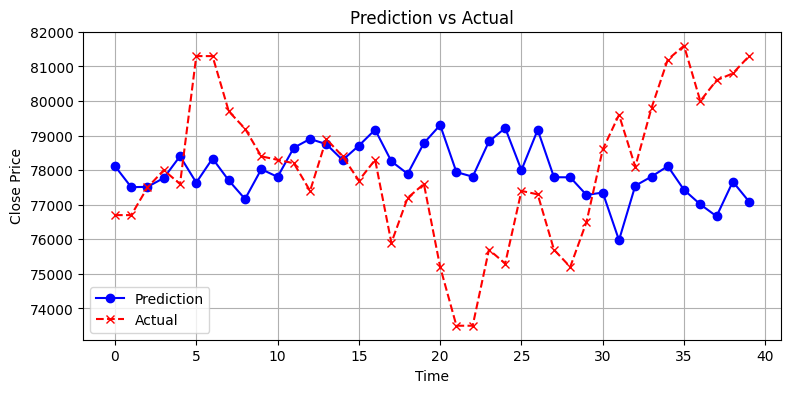

Root Mean Squared Error (RMSE): 2446.7438184850866
*************************************************************************************
[80245.46  79567.99  79928.21  81224.02  79869.92  77531.766 77944.91
 77627.266 76587.81  77920.74  75785.7   75977.67  75563.31  75574.64
 74137.5   74461.48  77395.78  80465.78  78377.91  79984.83  79956.55
 79988.81  81308.41  79271.16  79125.39  77402.65  78869.84  76657.86
 78269.39  78520.61  77916.32  78962.64  77823.47  78068.2   76105.25
 76532.62  76808.53  77503.984 78863.68  77021.266]
128 4 0.05 5 128


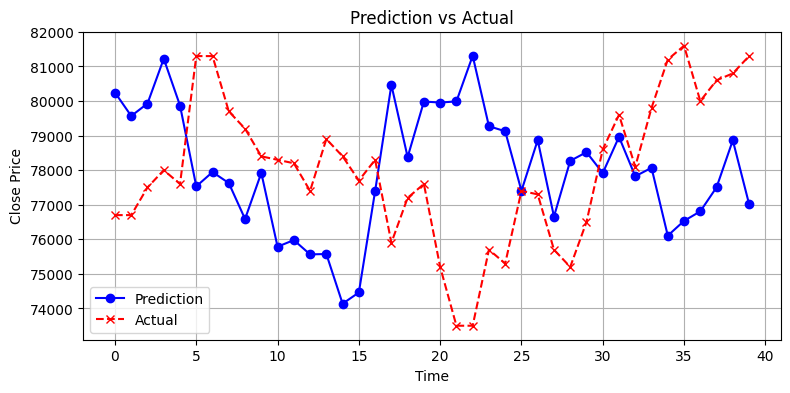

Root Mean Squared Error (RMSE): 3276.8780483939313
*************************************************************************************
[78570.78  78677.42  80356.07  77979.    77870.59  78044.7   77576.5
 78651.86  78702.19  78826.47  78042.68  77383.82  75365.13  76697.64
 77040.5   77566.26  78167.3   77223.28  76967.766 77273.71  76558.31
 77845.39  76445.125 77367.484 77906.625 77095.016 77837.516 77881.734
 78594.484 76917.32  77869.87  76925.88  76658.375 75894.31  77204.66
 75666.04  76829.28  77413.91  77571.38  77896.99 ]
128 4 0.05 5 256


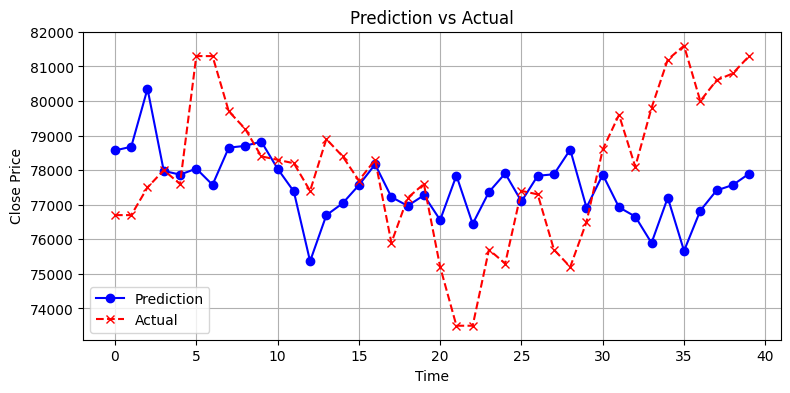

Root Mean Squared Error (RMSE): 2394.5999616556173
*************************************************************************************
[79579.03  80411.53  79013.02  77502.34  77720.63  78093.92  77645.45
 76795.234 78522.24  77742.42  76091.69  75299.875 76121.38  78128.52
 80969.74  77324.11  78989.44  80364.2   79522.28  77832.78  79628.555
 80299.41  78695.12  77565.78  79628.34  76914.16  78725.6   78054.42
 79670.8   78247.34  80195.45  82042.484 81023.    82001.91  79719.86
 81261.91  81337.05  79177.89  79910.36  82594.33 ]
128 4 0.05 8 128


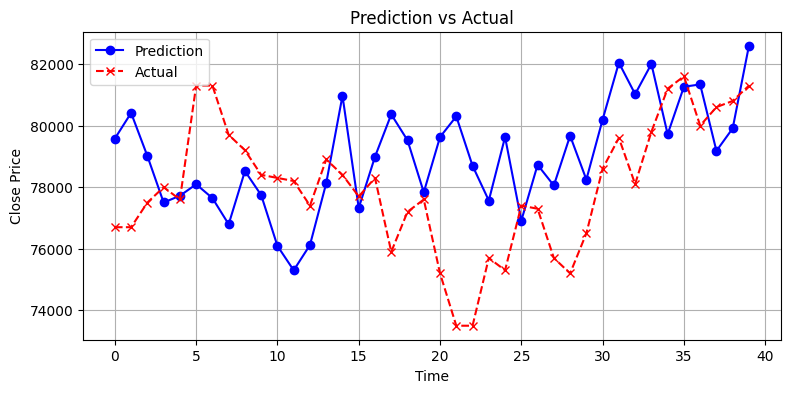

Root Mean Squared Error (RMSE): 2655.5652326489403
*************************************************************************************
[80971.78  80923.734 81711.27  80902.734 81932.54  80201.625 80908.57
 78145.97  78891.22  81332.59  81396.8   80592.25  80868.375 81958.17
 82275.06  81645.28  81756.32  80590.445 81296.484 79683.83  81775.19
 82720.86  81564.63  82721.34  81773.    81703.94  81680.81  80736.734
 79937.484 81964.125 79978.49  80162.83  80877.57  80880.99  81390.31
 80387.17  81603.07  82480.25  82417.08  82404.84 ]
128 4 0.05 8 256


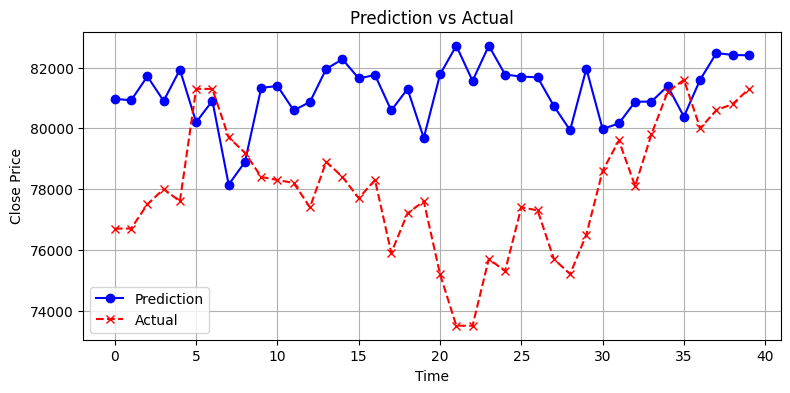

Root Mean Squared Error (RMSE): 3994.570283050616
*************************************************************************************
[77424.03  77287.57  78867.67  78848.08  78942.06  78078.87  76578.39
 77647.16  78989.336 78727.11  76638.82  78025.22  80782.93  79013.125
 79843.92  78848.25  80364.08  79197.19  80072.86  78764.125 79638.03
 79865.09  79171.766 79450.516 79544.67  81426.5   78674.766 80128.05
 79480.61  78441.03  78029.89  76519.58  80000.25  77590.62  78401.43
 78356.195 77989.37  78823.734 78334.695 76445.97 ]
128 6 0.01 4 128


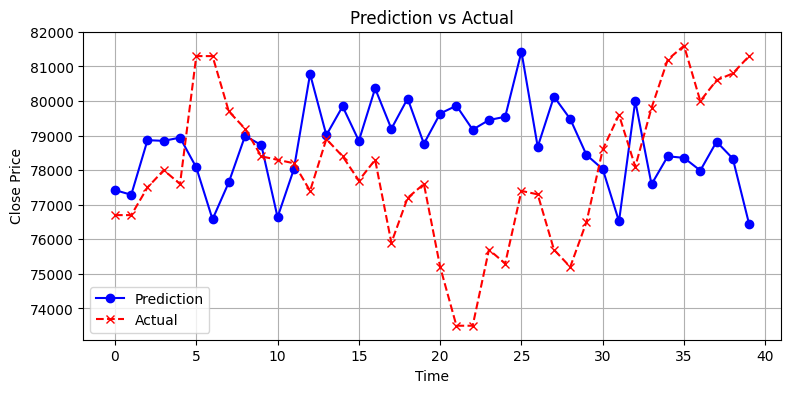

Root Mean Squared Error (RMSE): 2925.954224964903
*************************************************************************************
[78971.016 78471.44  79121.55  78355.695 76525.516 78133.03  78214.2
 77526.56  79819.766 77159.19  76184.766 76215.836 75510.07  77365.734
 77659.2   78345.88  78512.66  77966.76  78691.8   77873.08  77446.05
 76187.64  76361.66  76508.2   77482.08  76867.34  75860.734 76182.99
 76865.75  76674.45  76192.04  75418.484 76326.36  75158.89  75006.99
 76530.31  76378.164 76016.56  78527.17  76723.66 ]
128 6 0.01 4 256


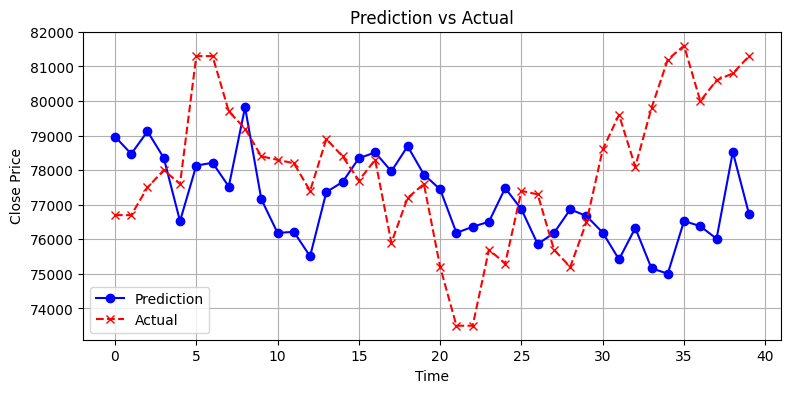

Root Mean Squared Error (RMSE): 2568.311032297235
*************************************************************************************
[78817.45  78388.14  78518.32  78622.09  76253.27  79204.516 79121.195
 78545.08  79769.625 79268.3   78532.09  78348.516 80274.95  78953.14
 78173.09  78781.19  78823.375 80720.    79387.88  80653.83  79074.75
 78336.19  79456.89  77966.16  77552.766 78990.305 78352.016 77265.375
 77473.234 77814.375 76042.3   76507.25  77748.234 76657.33  77587.66
 78446.93  77523.63  77426.766 79373.18  80057.336]
128 6 0.01 5 128


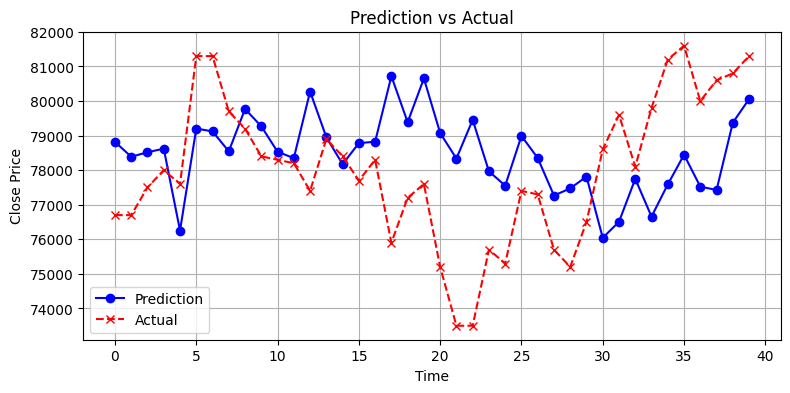

Root Mean Squared Error (RMSE): 2425.1994135390173
*************************************************************************************
[79462.33  75545.56  75300.766 74840.59  77828.45  76365.33  77936.05
 75928.17  78608.97  76101.516 72810.58  75370.375 73548.125 75376.11
 77545.94  74630.25  76697.84  76748.66  77233.74  73566.484 73729.08
 76435.53  76117.49  72640.09  75888.516 79105.734 77484.65  76215.5
 76946.31  75096.56  77042.125 77622.23  76087.2   75721.44  76305.836
 75881.77  75452.69  76589.33  77331.2   74246.945]
128 6 0.01 5 256


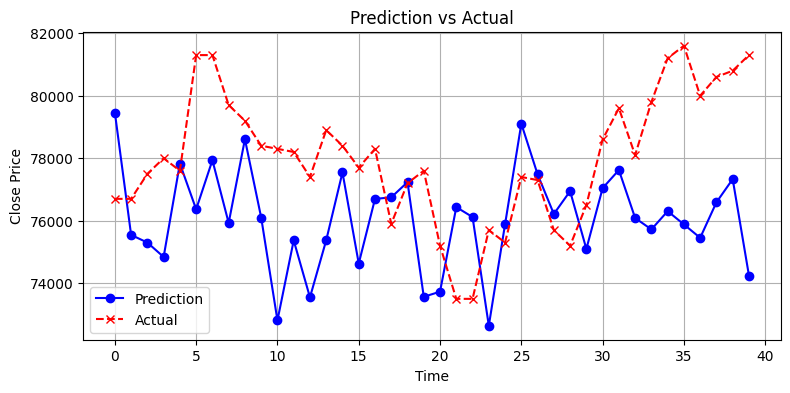

Root Mean Squared Error (RMSE): 3131.505428627324
*************************************************************************************
[80508.875 80446.03  80212.39  76777.91  78703.36  78524.5   77591.7
 74430.22  75836.266 76135.39  78993.88  76164.8   77007.75  78707.75
 77637.12  79253.1   79106.52  76028.8   79510.195 78995.41  75501.65
 77174.47  79766.53  77987.55  82520.11  76128.91  76071.72  75404.28
 77588.375 79368.16  75494.97  75815.91  77142.54  76978.96  78081.79
 72993.26  77049.266 75961.66  77936.89  76243.12 ]
128 6 0.01 8 128


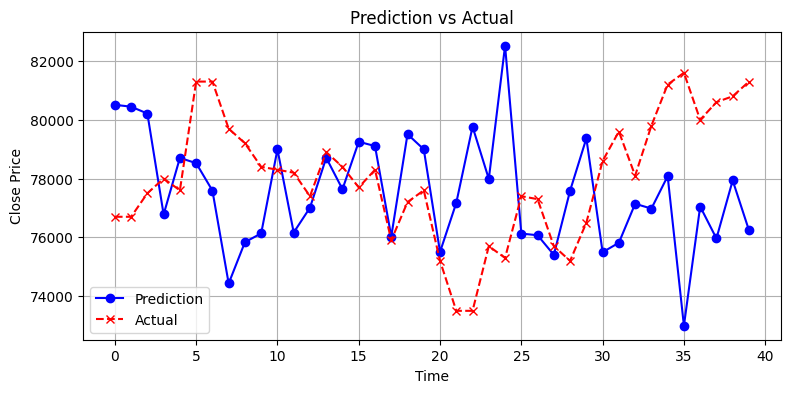

Root Mean Squared Error (RMSE): 3271.197639962052
*************************************************************************************
[79735.02  78373.9   81127.11  80020.32  77787.5   81137.31  78120.234
 77608.84  77438.766 77209.33  77182.7   77223.266 77581.52  77529.3
 75145.45  79656.92  78325.625 75387.266 78117.03  77325.8   77513.42
 77754.5   77911.09  78844.93  79250.445 78166.99  81059.69  80635.31
 78023.766 79204.22  78129.555 77702.92  78581.34  79678.44  80644.53
 80500.41  80853.766 79596.44  80257.84  76618.63 ]
128 6 0.01 8 256


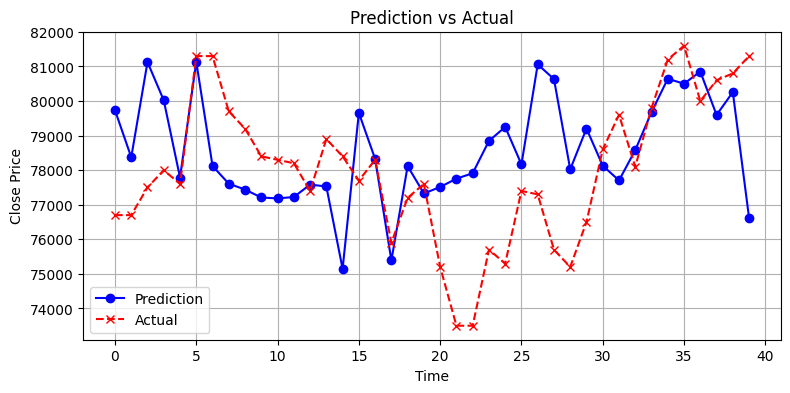

Root Mean Squared Error (RMSE): 2346.9945554903366
*************************************************************************************
[78231.3   79098.02  78772.234 79405.59  77972.59  79526.484 77423.74
 77053.53  77312.17  75938.305 78030.36  77970.19  77382.234 78615.52
 78144.39  78007.69  77756.14  77859.01  79156.03  79641.62  78904.69
 77958.234 79410.17  79201.33  79840.875 78204.664 78190.21  77648.38
 77138.48  78459.72  77657.07  79132.75  78343.94  78209.766 79057.61
 77612.44  78042.92  77519.68  77752.67  76809.22 ]
128 6 0.05 4 128


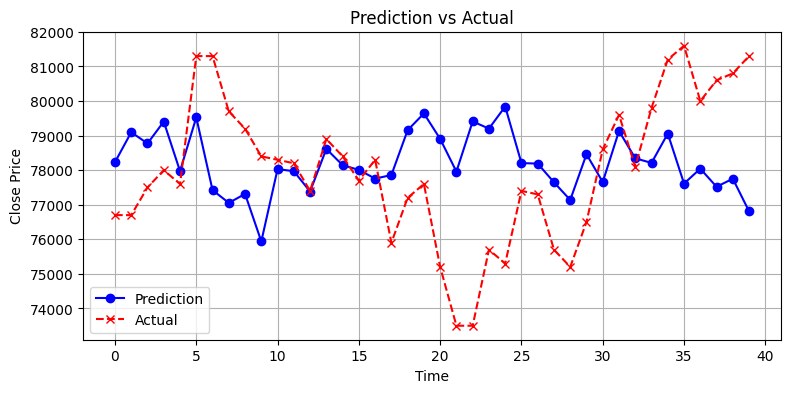

Root Mean Squared Error (RMSE): 2451.1395158820233
*************************************************************************************
[81772.08  78598.164 80098.58  79714.16  77820.03  78206.07  78809.28
 80788.97  78781.86  81113.44  79305.91  79217.81  79635.03  79979.57
 79504.164 81635.4   79375.51  79935.97  80867.3   79176.    80232.42
 78205.86  79467.03  78470.8   76119.83  77445.91  78719.78  78665.45
 78059.586 78361.67  77685.016 78939.85  79920.43  80266.54  78826.66
 79623.97  78295.516 79430.44  79311.56  80217.41 ]
128 6 0.05 4 256


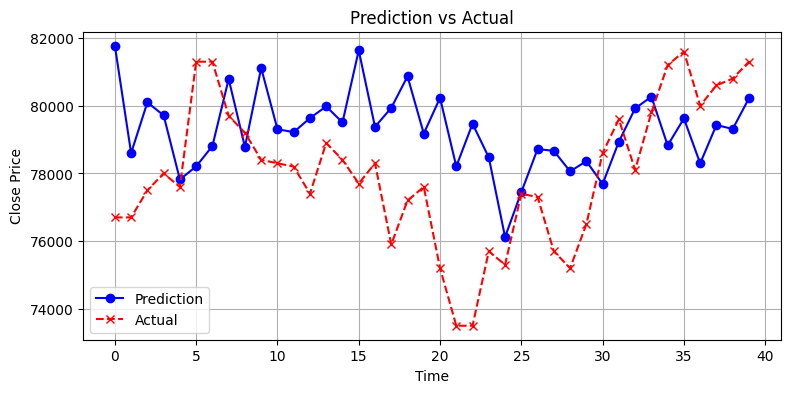

Root Mean Squared Error (RMSE): 2538.4269166258096
*************************************************************************************
[77227.69  79413.83  78475.22  78325.84  78003.6   78869.36  78109.32
 76592.03  78306.04  76696.09  76710.06  76355.36  78553.5   77218.16
 77172.625 78675.25  79181.44  78197.734 77929.75  77653.25  78090.41
 78097.14  79275.75  77284.69  77556.7   78904.31  77732.94  77020.19
 78396.06  78694.25  79013.484 76602.734 76945.    78748.86  79427.016
 78581.42  79378.75  78179.61  78853.45  78395.76 ]
128 6 0.05 5 128


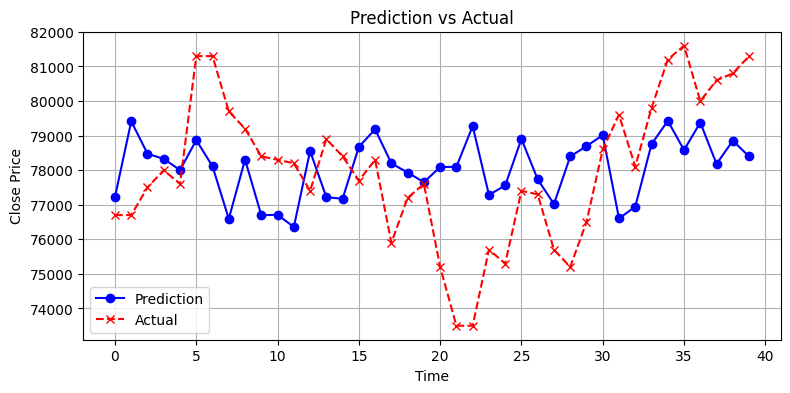

Root Mean Squared Error (RMSE): 2176.2578827494235
*************************************************************************************
[79241.234 77872.34  76285.05  75608.484 77517.7   76513.96  75602.375
 77984.33  77251.81  77591.53  75426.81  75279.41  74469.3   76256.41
 77186.7   77262.23  77380.81  76821.85  76014.09  75768.81  74643.125
 76587.48  76051.77  77321.18  77443.5   77555.14  76684.57  76158.945
 77523.69  76721.27  76351.28  75972.15  75764.21  76951.85  76600.39
 76094.15  76552.47  76774.73  76346.96  76559.86 ]
128 6 0.05 5 256


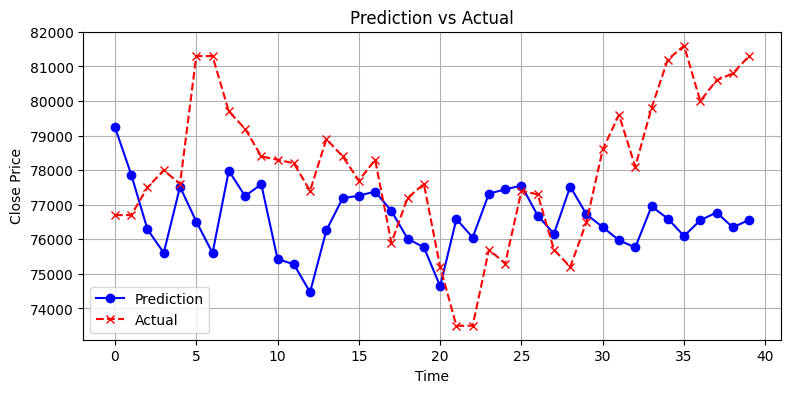

Root Mean Squared Error (RMSE): 2738.5637099255564
*************************************************************************************
[78170.36  77189.45  78278.97  78399.09  78438.57  77998.125 77745.61
 76696.95  77046.41  79726.89  78800.945 78821.83  78413.41  77069.01
 77142.914 78378.97  79384.68  78502.21  79087.66  78880.92  78781.45
 79356.19  81236.    80117.836 81567.42  81308.75  79754.24  81062.83
 80325.44  79101.97  77873.81  77649.84  77313.92  79579.95  79521.69
 78765.664 79187.305 79327.8   81030.1   79582.31 ]
128 6 0.05 8 128


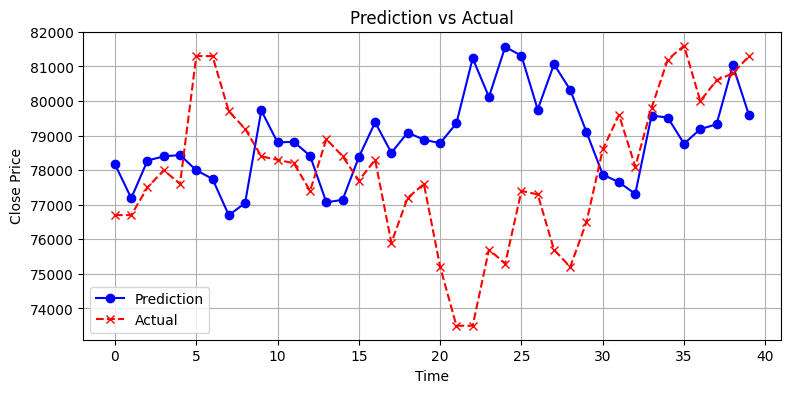

Root Mean Squared Error (RMSE): 2885.440844134725
*************************************************************************************
[78944.68  79794.22  79171.53  80057.61  78986.09  78153.55  79884.
 79587.66  78239.984 76875.56  76760.95  77958.35  76506.53  76772.5
 78725.695 79032.6   78518.51  78596.31  79834.06  78915.61  76881.74
 79842.766 77957.195 76493.94  78320.2   79316.2   80466.7   78437.27
 77747.13  77846.86  78506.55  77272.97  78430.08  77744.266 76733.25
 75813.92  76032.7   76024.03  75542.734 76072.93 ]
128 6 0.05 8 256


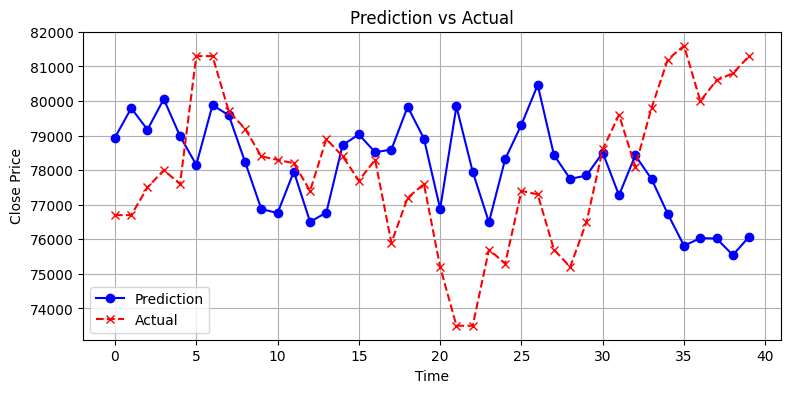

Root Mean Squared Error (RMSE): 2834.373679683424
*************************************************************************************
[76137.984 74551.484 78476.55  78302.55  79411.375 78002.03  80058.47
 77954.375 77481.375 76245.41  77693.484 79091.22  74786.234 75383.69
 72503.125 76007.74  75862.25  73685.39  72466.76  75147.08  74572.625
 74320.63  74743.9   75448.125 78224.3   74423.15  75134.016 73856.97
 73608.18  75495.125 74261.516 73748.695 75778.61  74668.09  74715.266
 75001.28  70771.08  75645.3   74554.68  75609.37 ]
128 8 0.01 4 128


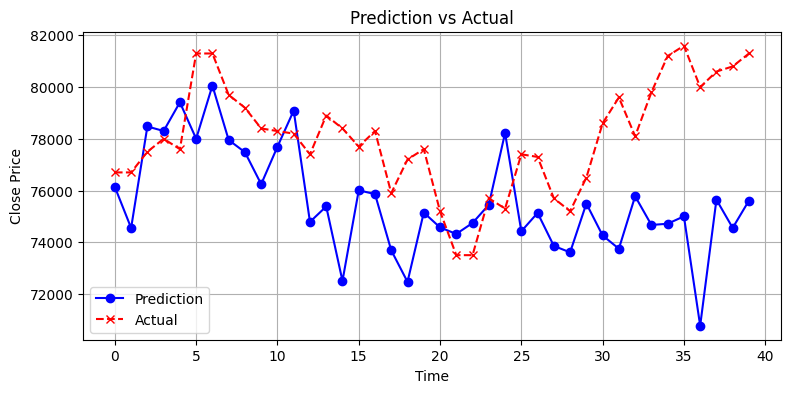

Root Mean Squared Error (RMSE): 3580.4845679381137
*************************************************************************************
[81067.55  78001.72  75697.375 75007.23  75663.81  75867.09  73858.43
 76331.16  76217.664 74387.64  75768.42  77415.87  75914.125 77170.39
 78647.53  77951.266 78162.375 78418.36  78199.36  78345.53  77897.84
 76581.29  77062.31  76704.87  78055.72  77748.83  76791.83  78167.62
 76267.78  78273.    77942.33  78984.625 78225.72  78424.55  77534.11
 76005.125 78611.47  79002.625 78937.88  80554.58 ]
128 8 0.01 4 256


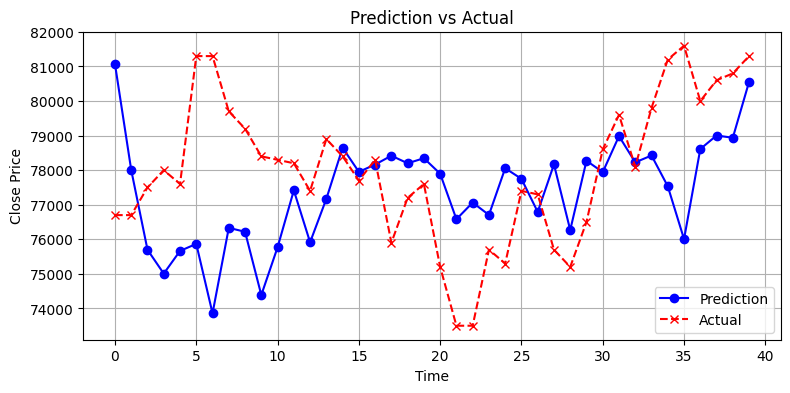

Root Mean Squared Error (RMSE): 2659.916572454522
*************************************************************************************
[80423.484 80974.55  78794.44  79599.58  79442.66  78394.766 79239.84
 79248.33  79718.44  78221.2   77310.766 78744.45  78490.12  79420.64
 79148.64  81318.09  81129.875 79561.21  81006.    81576.195 80551.86
 78718.555 80600.45  79590.695 81043.375 81678.234 78295.07  79672.08
 79155.32  80223.58  79600.11  80995.26  79342.336 80300.22  79206.016
 78562.016 79477.305 80163.19  79783.11  80160.08 ]
128 8 0.01 5 128


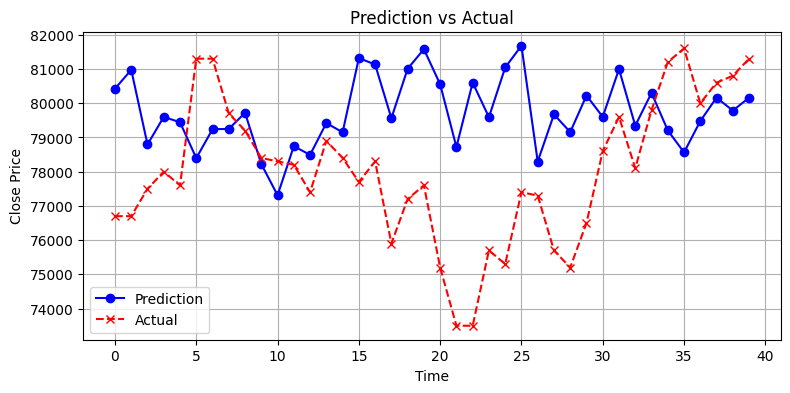

Root Mean Squared Error (RMSE): 3003.2851491532792
*************************************************************************************
[79190.85  79073.19  79935.75  79589.46  82219.44  79447.43  79760.61
 81785.67  78099.41  78999.95  80561.36  79116.734 77758.41  80149.56
 79833.34  77296.61  80056.88  79775.77  79183.55  78548.4   75396.2
 78490.53  79495.31  79005.766 78667.266 79269.71  79643.81  78966.266
 80902.875 79234.28  81151.22  79370.766 78252.805 78682.234 79310.67
 80427.98  78821.3   79079.734 80930.43  80835.555]
128 8 0.01 5 256


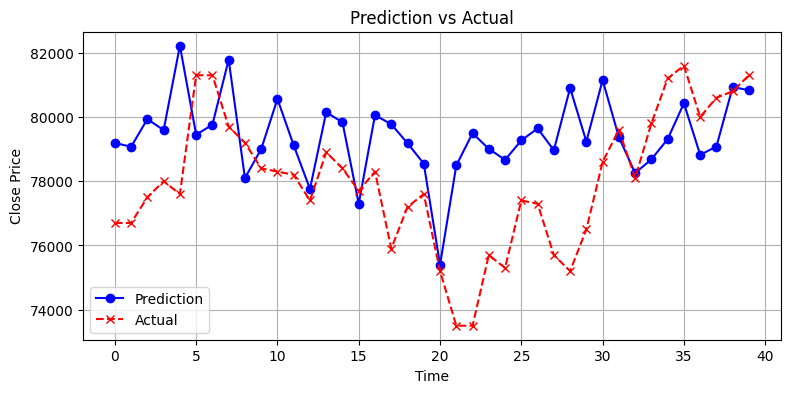

Root Mean Squared Error (RMSE): 2478.3199481449587
*************************************************************************************
[77957.29  78749.7   81230.46  79478.25  78252.17  79104.25  78526.125
 78053.5   76338.164 76165.87  76029.09  77362.44  77926.57  78076.01
 76974.67  75821.33  79322.305 76994.92  77376.52  77772.305 77953.07
 80628.734 78741.87  80388.64  79613.04  77484.16  78215.69  76476.984
 78947.37  78749.72  79168.8   77314.51  75760.43  77928.39  75961.9
 78693.42  76889.91  77735.16  77019.99  77708.19 ]
128 8 0.01 8 128


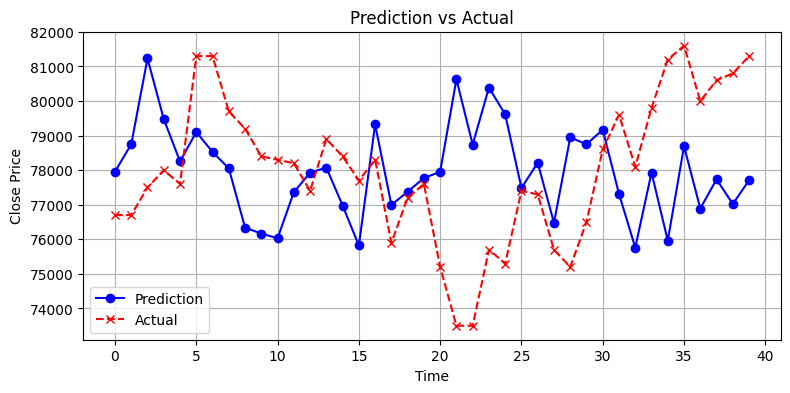

Root Mean Squared Error (RMSE): 2774.396163508404
*************************************************************************************
[80022.06  80070.02  81307.266 78729.664 78035.086 78958.8   78807.56
 75638.94  77969.92  77757.55  77820.805 77763.65  78082.67  77304.836
 79095.766 79679.125 79404.2   77116.67  80024.17  81114.67  78684.55
 78555.33  77890.97  78576.73  75520.65  77748.03  78325.81  76939.086
 76993.01  77805.22  77642.695 76752.05  77866.61  76769.234 77383.69
 77425.86  77956.94  79490.52  79221.586 80919.8  ]
128 8 0.01 8 256


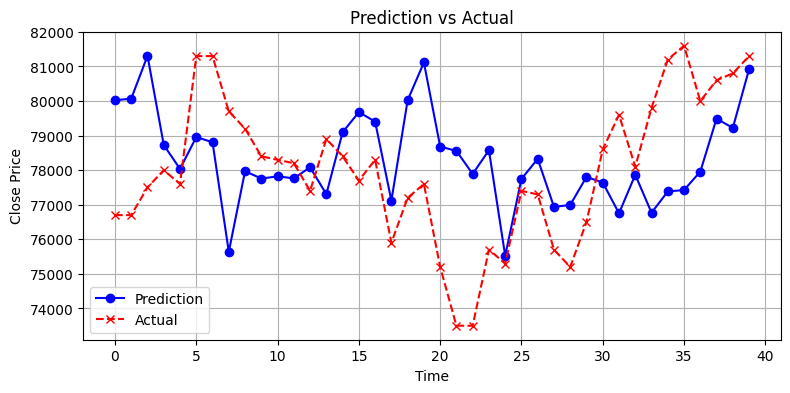

Root Mean Squared Error (RMSE): 2396.9156679958405
*************************************************************************************
[80196.79  80142.33  80324.73  78969.36  79705.11  78806.97  78007.18
 78664.84  77893.95  79446.14  77770.28  78192.34  77019.11  76775.75
 76507.16  79092.03  77996.84  77889.    78607.28  78592.8   80127.36
 78677.31  79013.88  78253.81  78938.3   78522.81  76413.055 79348.33
 78072.65  77883.17  78614.54  78578.45  78864.414 79185.56  79512.83
 78825.44  78298.414 78513.97  79282.22  78296.234]
128 8 0.05 4 128


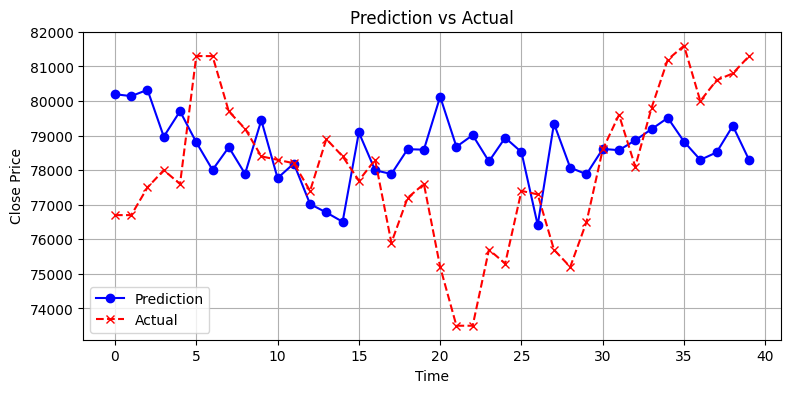

Root Mean Squared Error (RMSE): 2417.2395538243236
*************************************************************************************
[78135.336 77825.19  78047.7   77300.55  78924.836 78365.1   76879.53
 76131.91  76005.03  76753.28  77171.94  75984.25  76606.664 77370.86
 76305.51  77362.09  76767.72  78181.734 77582.734 77234.36  77242.56
 77907.66  78272.17  77020.766 78642.625 78526.05  78661.39  78619.28
 78739.67  78529.55  78610.664 78325.82  78541.57  78005.6   80169.36
 79222.25  77967.06  78604.62  78030.875 77058.95 ]
128 8 0.05 4 256


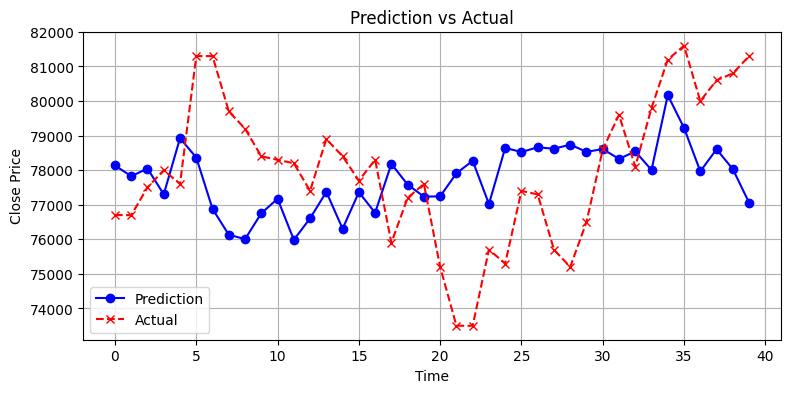

Root Mean Squared Error (RMSE): 2314.4476447779266
*************************************************************************************
[79326.2   79880.125 79835.625 79293.39  79748.61  77125.83  78558.83
 78426.54  78018.18  77171.19  78128.64  76926.266 77319.81  78680.05
 78833.31  79526.66  82094.734 81905.45  80730.195 81022.78  81370.39
 80893.11  79745.96  79590.45  79713.586 79348.02  79806.46  80079.42
 79195.875 80893.57  80526.9   80046.984 82754.25  82156.484 81220.09
 80746.45  81714.734 80242.06  82814.71  82070.28 ]
128 8 0.05 5 128


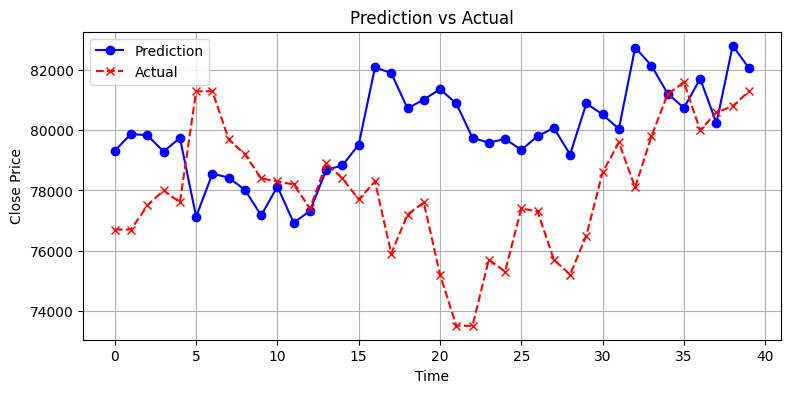

Root Mean Squared Error (RMSE): 3195.9297346490716
*************************************************************************************
[80821.95  78808.22  80835.3   78856.125 78833.625 78312.8   78928.8
 76565.14  75219.734 76655.72  76260.61  75546.984 75268.586 76209.09
 76114.2   78156.84  79095.78  78784.94  77456.53  78844.41  78195.37
 77739.3   78603.875 78664.45  76956.234 76986.8   78447.17  77473.58
 79542.125 79096.51  78708.125 77087.53  76445.11  76680.26  74927.81
 75076.7   77169.83  77067.67  76699.55  75830.21 ]
128 8 0.05 5 256


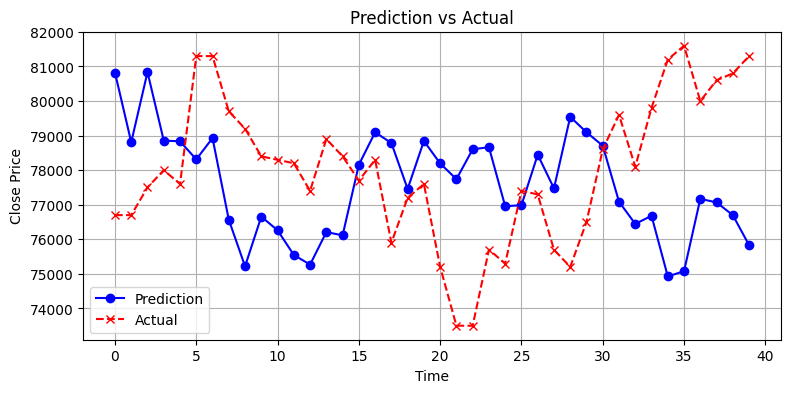

Root Mean Squared Error (RMSE): 3081.0697228270724
*************************************************************************************
[78435.2   77506.14  77683.22  77647.67  77124.81  77080.305 78031.55
 77944.51  76527.33  76517.58  75761.09  76703.3   75548.85  76383.92
 76338.59  76508.47  77200.67  76814.16  77242.734 75805.59  75958.58
 76480.17  76101.43  75921.16  75993.53  76327.22  75801.266 75905.84
 76674.05  76275.58  75920.8   75494.305 75538.91  75889.2   75880.36
 76550.61  75814.2   76149.586 76267.81  76866.34 ]
128 8 0.05 8 128


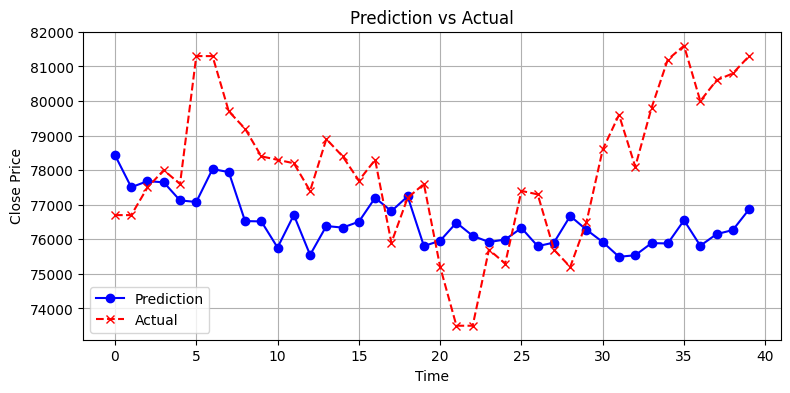

Root Mean Squared Error (RMSE): 2623.476839399316
*************************************************************************************
[80307.2   81189.5   79913.25  79268.32  81214.09  81434.87  79922.98
 80186.914 79584.45  80174.734 78770.516 78157.734 79125.16  80175.81
 80385.57  79878.25  80280.49  80237.39  79508.08  78381.67  79110.01
 80897.14  80118.5   80824.77  79859.94  80965.836 80620.66  80793.97
 81220.055 79994.016 80592.305 81057.56  82018.445 81379.02  81037.21
 79910.84  79401.99  80323.39  79528.    79792.836]
128 8 0.05 8 256


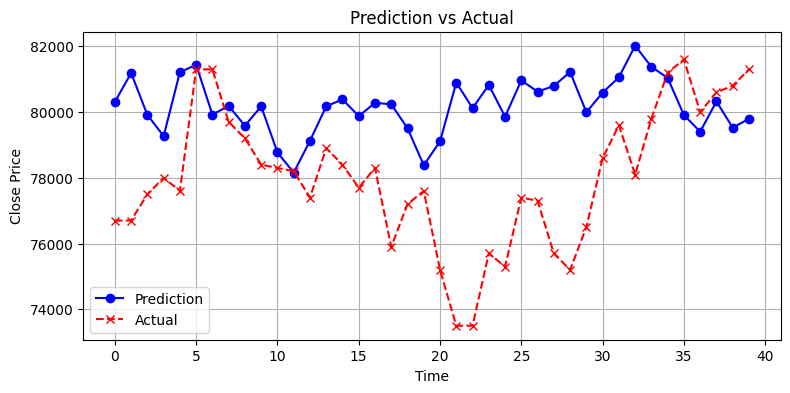

Root Mean Squared Error (RMSE): 3128.296224893802
*************************************************************************************
[80760.93  78309.13  78149.3   77996.59  75114.64  74542.59  76733.41
 78865.78  80283.67  78279.414 80403.32  77155.2   75250.45  76690.08
 75649.78  75544.586 77400.72  76177.414 75668.19  78657.28  75559.16
 77516.555 77728.35  75581.86  75772.17  75764.28  80217.94  76468.58
 76267.2   76208.44  75231.8   73029.82  75223.86  78155.516 77017.12
 76782.61  76041.516 77177.39  77015.42  76828.8  ]
256 4 0.01 4 128


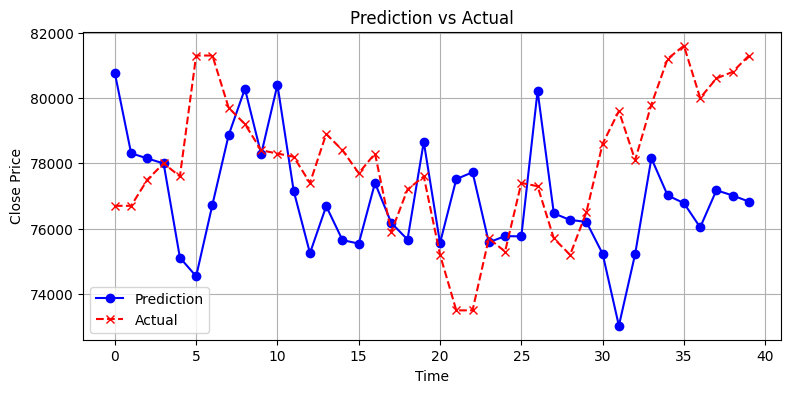

Root Mean Squared Error (RMSE): 2919.4714469353567
*************************************************************************************
[82405.75  81186.875 79453.8   79159.44  77220.72  84296.25  78686.58
 78355.94  80619.734 80231.37  78874.02  78508.72  76263.11  76148.02
 75412.375 78788.84  81141.586 80843.92  77494.29  79990.53  78783.26
 81891.81  79540.516 82245.58  76781.734 77161.41  78102.03  77396.47
 78164.32  79539.    81201.09  76048.1   78706.26  78526.53  78809.17
 78386.54  79309.4   77423.414 78993.484 75419.695]
256 4 0.01 4 256


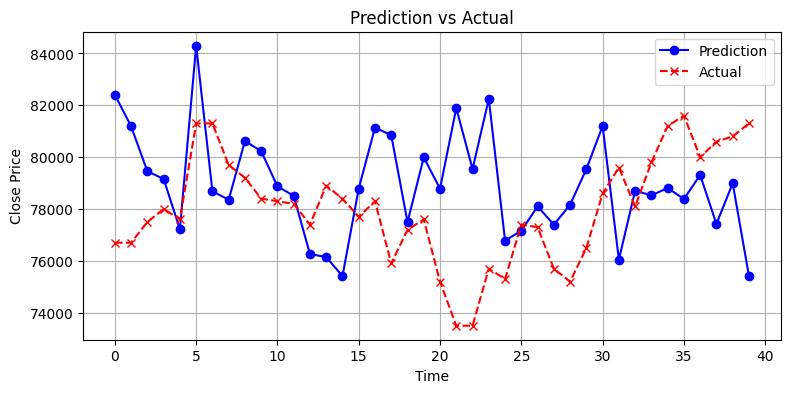

Root Mean Squared Error (RMSE): 3205.115496027986
*************************************************************************************
[79895.67  77530.2   77958.72  79286.81  77817.09  77072.06  76812.56
 79326.32  79731.734 76456.375 78590.68  78489.125 77862.44  78112.47
 77077.31  78621.945 77899.11  75591.266 77616.    77690.24  76934.836
 74866.07  74518.13  77159.62  75376.81  76152.086 76424.22  76779.91
 79231.79  75910.63  76244.4   75249.875 78186.81  79642.51  77141.88
 76397.7   79345.734 80828.66  77798.33  75556.375]
256 4 0.01 5 128


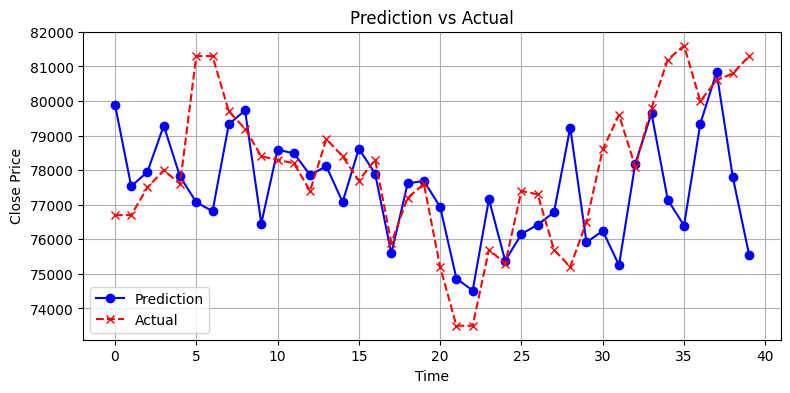

Root Mean Squared Error (RMSE): 2223.313967678407
*************************************************************************************
[78811.42  78881.414 77659.59  79031.93  77883.94  78820.08  79519.77
 76654.19  79757.5   79799.65  78209.7   75931.95  75241.31  77013.99
 76416.164 76707.086 78056.516 76522.21  78898.23  77068.06  76545.28
 76553.54  76312.76  76814.44  77635.36  74929.414 76272.05  75748.625
 77680.22  77164.55  76375.31  76700.336 75454.95  76329.22  78245.29
 76400.97  77195.5   76407.305 76002.34  76669.95 ]
256 4 0.01 5 256


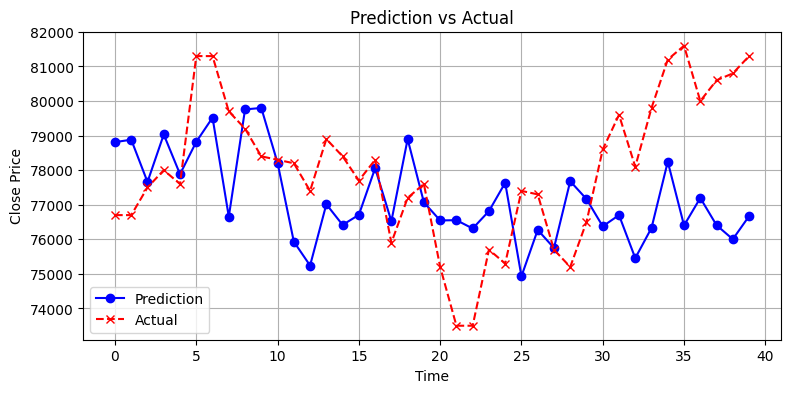

Root Mean Squared Error (RMSE): 2401.6340412191885
*************************************************************************************
[79924.86  80324.5   81678.22  79399.016 79340.99  80119.66  79698.19
 79093.23  79297.06  79854.375 79306.5   77346.98  79099.766 79249.44
 78622.125 77388.53  78109.83  79800.59  78662.69  81395.375 78963.89
 79541.09  80505.06  77658.86  79675.984 80511.67  79857.17  79708.51
 79751.5   76006.375 78360.69  75881.92  79571.64  78708.8   77263.81
 77150.81  77254.14  75461.375 77234.625 76729.016]
256 4 0.01 8 128


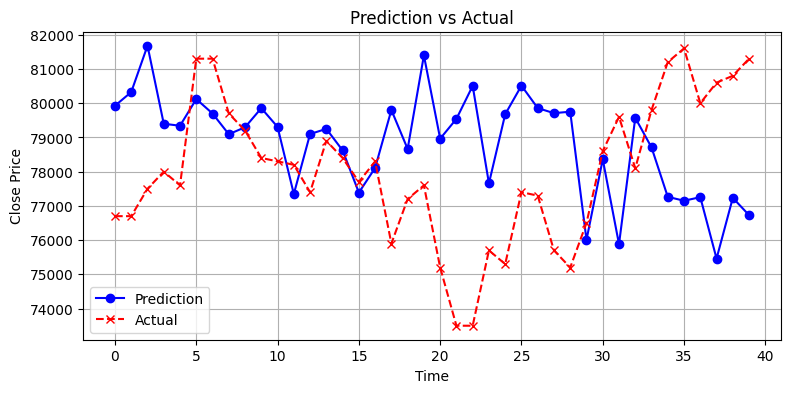

Root Mean Squared Error (RMSE): 3103.1195401975115
*************************************************************************************
[81239.84  80688.83  80601.54  79713.07  82020.08  79512.375 78450.56
 80112.44  80575.266 79729.06  79640.56  79152.1   81575.42  79102.375
 79664.66  79992.766 79201.766 79201.484 80210.234 78978.7   80237.625
 79782.81  79000.53  81052.42  79456.36  79080.984 76278.8   75824.836
 78433.19  79026.45  78050.086 77368.53  72700.33  76308.234 76506.86
 75443.875 77558.234 78724.7   78345.82  79745.91 ]
256 4 0.01 8 256


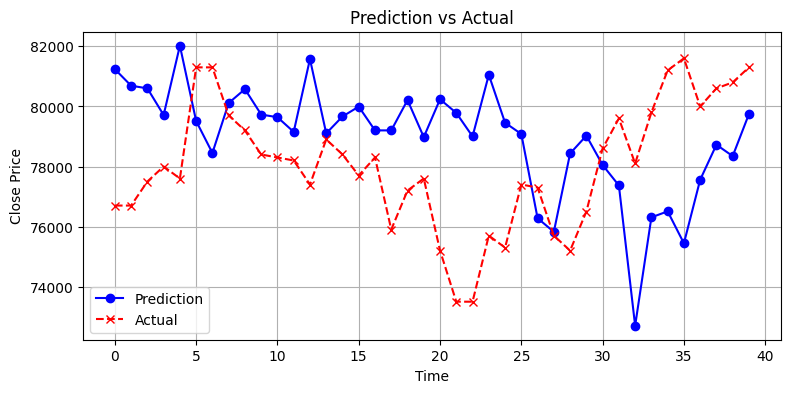

Root Mean Squared Error (RMSE): 3239.1667228661695
*************************************************************************************
[78715.766 76946.734 76943.875 78256.5   77971.63  77255.5   77844.32
 77568.16  76547.72  77311.766 75185.06  77551.72  76173.45  76485.61
 76447.766 76542.94  77216.82  77013.03  77485.94  78344.53  77486.59
 76289.81  77300.42  78193.09  76272.25  75479.    74032.83  74557.59
 73908.05  77305.53  75984.79  74962.83  75373.44  75752.61  74822.914
 75192.55  75290.16  75323.43  77241.375 75471.69 ]
256 4 0.05 4 128


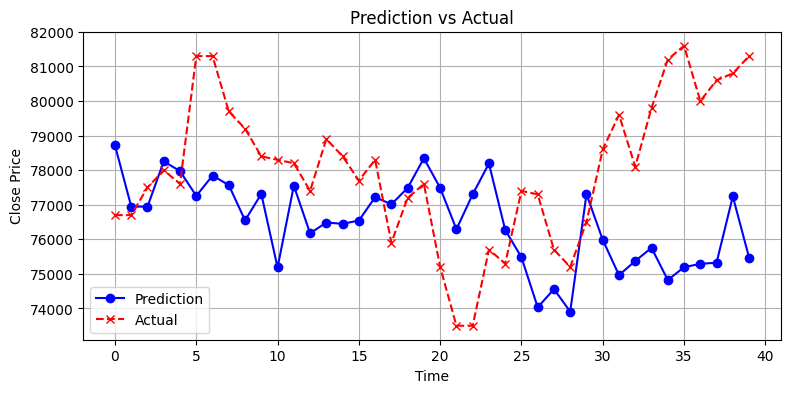

Root Mean Squared Error (RMSE): 2976.9857664419596
*************************************************************************************
[78903.81  78333.23  78208.805 78625.95  78584.266 80454.59  81800.82
 79755.17  79532.875 79971.81  78039.336 77661.16  76082.375 76660.11
 78209.9   78444.234 80340.08  77614.09  78328.5   79759.164 79377.234
 78398.375 80096.375 80179.625 79977.195 79693.625 77569.56  77067.72
 76896.91  77013.34  78086.09  76893.    75724.43  77958.39  77711.02
 76721.57  77606.625 79165.64  78378.695 77350.266]
256 4 0.05 4 256


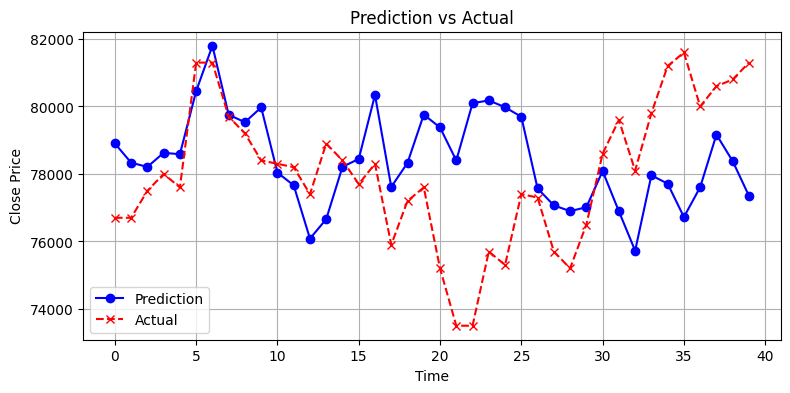

Root Mean Squared Error (RMSE): 2513.800221318777
*************************************************************************************
[78703.586 79326.984 79158.39  78944.5   80041.4   78736.81  78479.79
 78511.12  77680.586 77369.67  78759.45  76183.78  78282.75  77716.41
 78394.7   76984.76  78388.89  78385.34  78610.55  79159.734 76780.76
 76842.11  77543.984 78416.516 76841.08  76679.35  77336.945 77056.97
 76928.125 76346.7   77456.34  75872.61  77595.266 78664.625 78234.19
 77245.44  77579.555 77955.89  78831.28  77910.81 ]
256 4 0.05 5 128


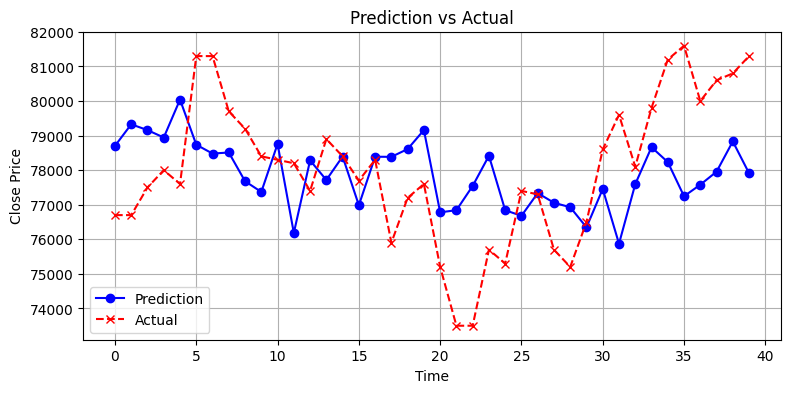

Root Mean Squared Error (RMSE): 2093.23319132503
*************************************************************************************
[77374.79  77558.89  78793.67  77799.516 78682.38  77965.35  78380.3
 75871.78  75958.4   76126.484 76686.49  76174.22  76210.83  74797.89
 76707.31  73806.41  73265.46  75233.58  75333.21  74167.02  76030.5
 75936.66  76372.25  75761.65  75512.31  77120.516 77868.39  76066.17
 75781.84  77084.586 75903.875 74616.984 75164.41  74855.89  76208.94
 77605.47  74975.3   75257.78  76666.04  76709.61 ]
256 4 0.05 5 256


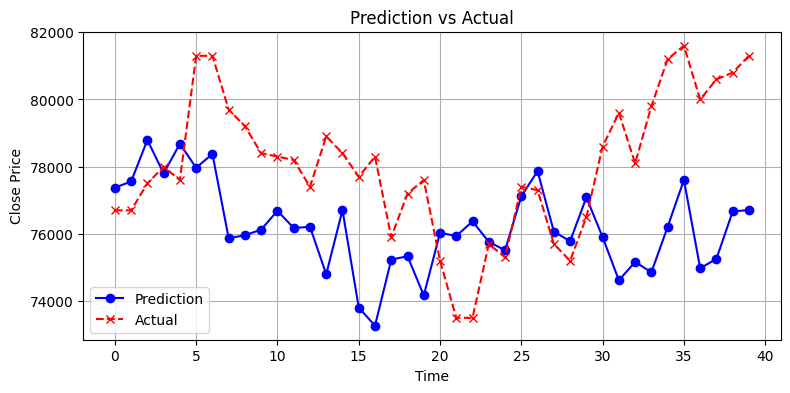

Root Mean Squared Error (RMSE): 2967.3549818942615
*************************************************************************************
[77853.33  80353.    78833.75  79764.32  78299.336 77614.41  77509.8
 78520.44  76453.56  76457.72  75844.86  77031.69  77741.91  76404.125
 76401.266 76382.234 76451.05  77664.3   77366.375 80370.15  76940.055
 78957.11  77989.12  76545.12  76387.07  75922.734 75167.68  75906.375
 73738.83  74925.42  75022.42  74288.84  75561.41  76440.016 75638.61
 74852.39  75676.16  75626.47  76599.33  78576.65 ]
256 4 0.05 8 128


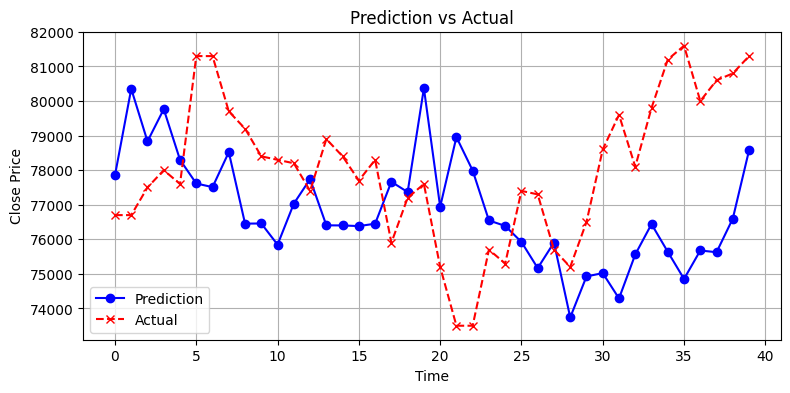

Root Mean Squared Error (RMSE): 3018.075188139171
*************************************************************************************
[76708.734 77220.31  77960.32  78406.39  78351.89  78677.89  77846.28
 77537.195 78233.234 76948.766 77814.125 78107.195 77923.22  77828.89
 76908.11  77683.12  77354.68  75574.68  76537.5   76541.83  77627.22
 76702.66  76556.17  76699.69  76705.86  76135.36  77105.72  76556.81
 78851.66  77355.72  75581.5   76568.36  77260.484 76257.805 77545.97
 77004.2   76628.39  78173.5   77937.3   78412.31 ]
256 4 0.05 8 256


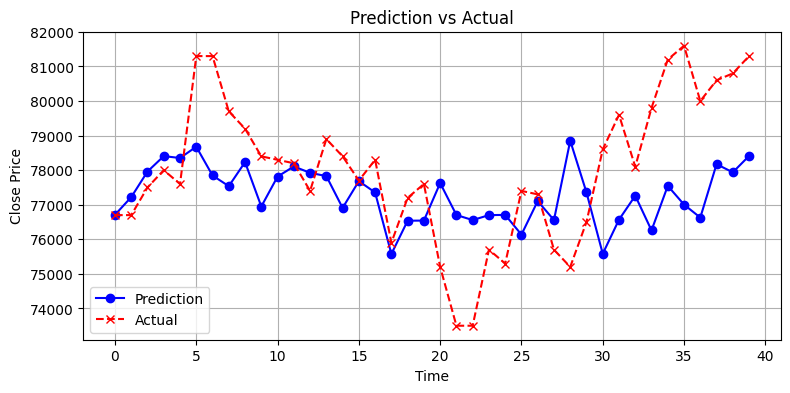

Root Mean Squared Error (RMSE): 2114.8546842087094
*************************************************************************************
[78643.234 80477.125 78904.195 78925.336 81359.945 80394.375 77676.69
 78312.69  75849.805 78641.266 76692.9   80999.3   80663.56  77384.484
 79896.26  77300.75  75964.19  78168.96  76142.484 78073.414 76243.47
 78067.03  80940.41  79074.55  78542.64  79202.3   77694.8   79936.61
 79021.34  79155.89  82110.18  82077.03  78170.16  78524.93  78244.5
 77879.8   77024.41  76608.    77831.2   79173.914]
256 6 0.01 4 128


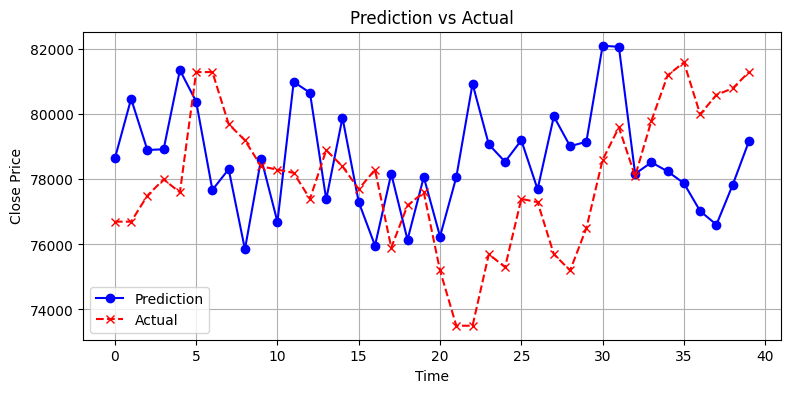

Root Mean Squared Error (RMSE): 2841.123846790852
*************************************************************************************
[79931.41  77697.266 77576.83  79871.625 77903.484 78276.92  76371.64
 77774.2   77466.89  76588.99  76654.78  76988.84  76438.66  74943.55
 76520.734 77620.195 78739.125 77581.19  76225.84  80123.336 77124.766
 78505.95  78346.44  80749.5   75754.93  77593.03  73384.375 73869.91
 79304.92  76518.484 76186.58  75423.766 75091.08  75877.31  75457.17
 76111.2   76967.15  79934.92  77929.516 75812.26 ]
256 6 0.01 4 256


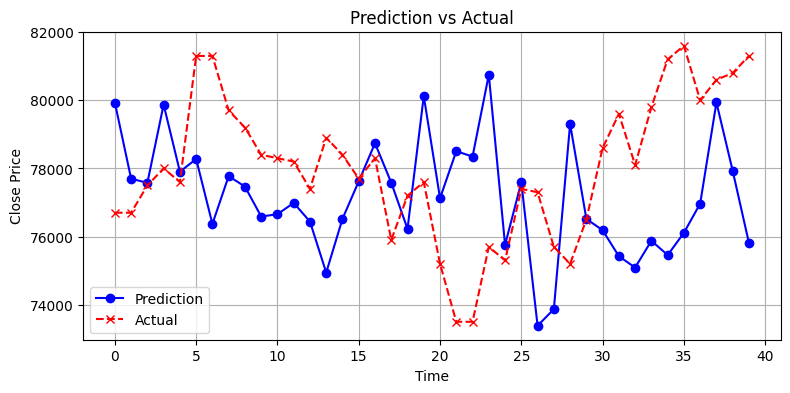

Root Mean Squared Error (RMSE): 3022.4875605728716
*************************************************************************************
[78554.44  77071.59  80090.93  78177.58  77122.49  79133.4   76460.68
 77432.72  78021.87  77661.59  75406.03  76989.68  76461.89  76960.28
 77501.97  77875.42  77526.266 79799.984 79531.68  77002.875 75457.43
 77522.234 79428.266 74912.664 74518.14  76062.19  78283.31  79606.
 77772.16  78040.11  75397.445 76845.36  79629.625 79435.1   77755.45
 76813.81  76997.93  80156.59  79307.22  80199.945]
256 6 0.01 5 128


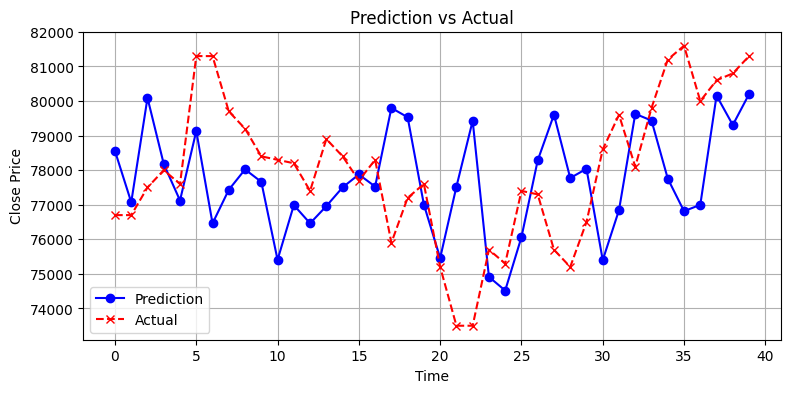

Root Mean Squared Error (RMSE): 2398.0041567657436
*************************************************************************************
[78283.81  79400.75  78187.    79326.2   78111.73  76129.5   78535.09
 77163.83  79603.55  77968.22  78642.2   79943.7   79046.54  78838.3
 77392.72  77473.07  80293.91  79327.73  78659.45  78681.34  78448.54
 80907.11  79304.6   78537.74  77607.016 78934.88  81960.66  78343.84
 77607.34  81475.25  77236.07  78068.336 75968.08  77458.55  75496.69
 78285.5   78827.44  78435.94  77956.516 79363.83 ]
256 6 0.01 5 256


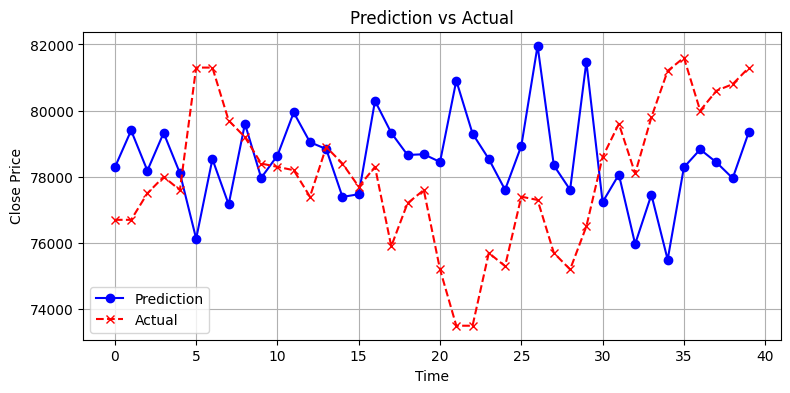

Root Mean Squared Error (RMSE): 2868.626321637293
*************************************************************************************
[79987.33  83884.7   81193.34  79346.91  78083.    79966.95  80885.
 82348.39  84106.56  80380.56  78317.516 82164.31  79513.734 82077.5
 80661.695 80835.95  80828.734 84770.25  79292.945 84109.766 81233.56
 81986.83  79874.03  77375.39  82254.23  76416.46  78486.67  80427.62
 84420.31  82562.77  79500.984 77982.45  80738.414 81066.664 73977.51
 79340.664 79274.25  81824.805 82697.39  80540.586]
256 6 0.01 8 128


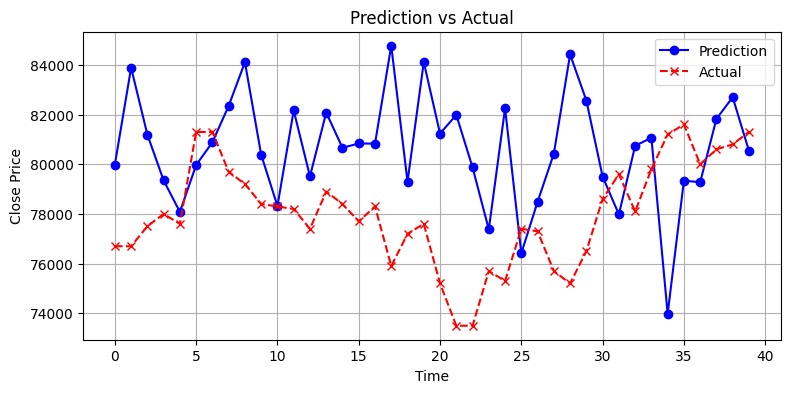

Root Mean Squared Error (RMSE): 4225.898081189671
*************************************************************************************
[81582.    76986.3   78780.69  77973.38  78840.58  78919.6   78164.41
 78887.2   80865.05  80415.95  78577.66  78816.43  78946.234 79616.625
 80216.59  80094.47  79888.47  77908.11  80367.8   80074.94  79799.016
 77794.43  80526.15  80019.58  79566.195 79655.03  77959.8   76238.94
 77750.34  77828.34  78196.836 78898.81  79262.414 79990.53  77518.78
 78262.44  77426.016 79698.16  78419.14  80081.95 ]
256 6 0.01 8 256


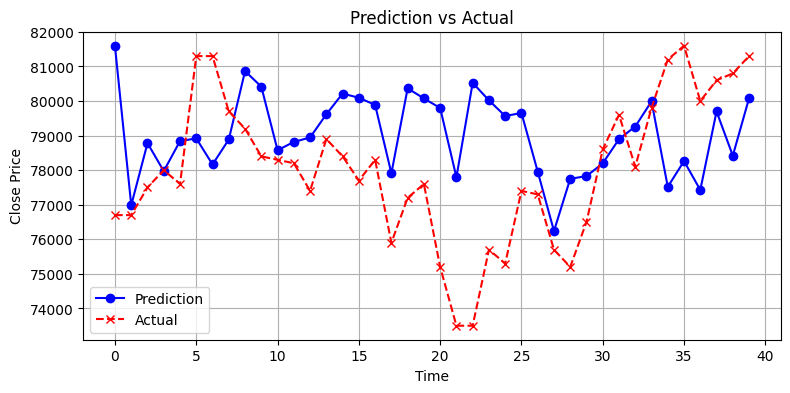

Root Mean Squared Error (RMSE): 2580.814048309782
*************************************************************************************
[79259.8   77520.61  77860.234 78587.68  77043.91  79450.28  78124.69
 79067.82  78927.92  78535.38  79385.95  79383.59  77023.47  78700.05
 78667.16  77851.17  78811.79  78956.14  77340.72  79652.39  78617.85
 79688.95  80854.66  80068.15  80893.91  79152.74  79742.766 78634.17
 78151.445 78108.78  77939.75  79020.72  78824.75  78795.81  76356.88
 78768.49  78845.88  76631.875 76373.55  78778.81 ]
256 6 0.05 4 128


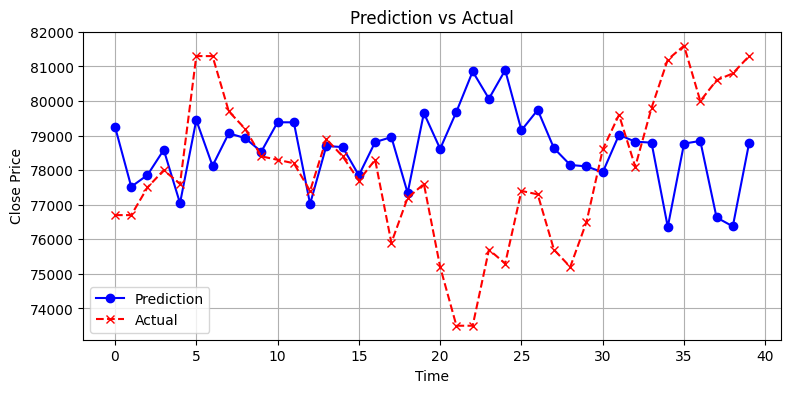

Root Mean Squared Error (RMSE): 2733.582677561517
*************************************************************************************
[78936.94  79026.47  78129.9   78419.42  76959.31  76784.555 77000.89
 77128.92  77136.13  76697.305 75113.    75059.53  75285.61  74845.
 76291.17  77011.2   76636.71  76675.234 75180.305 77426.86  77077.81
 78447.875 77978.94  77967.625 77471.03  76539.59  75004.    75370.266
 75286.15  76399.875 74472.945 75978.2   76203.125 77405.09  74908.14
 75349.58  75886.586 75815.89  77155.16  74878.016]
256 6 0.05 4 256


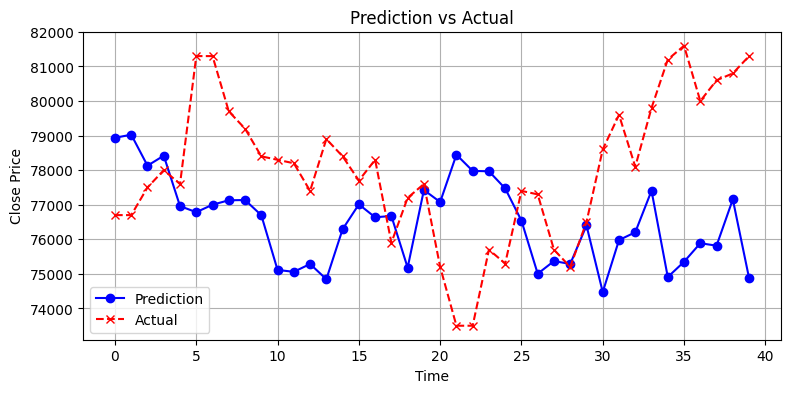

Root Mean Squared Error (RMSE): 3138.1023101760698
*************************************************************************************
[77780.195 76399.375 77439.74  77542.22  76987.984 77526.92  77057.
 76884.22  79092.93  76385.67  74799.805 75196.88  76390.21  75152.96
 74481.445 76765.875 78192.8   76716.984 77469.45  75773.92  76232.27
 74016.234 77106.625 76674.484 76014.125 75386.766 73524.16  73888.72
 74166.8   75204.875 76135.05  73811.44  73932.14  75975.7   75263.19
 76137.18  75410.35  76053.11  75988.08  76374.41 ]
256 6 0.05 5 128


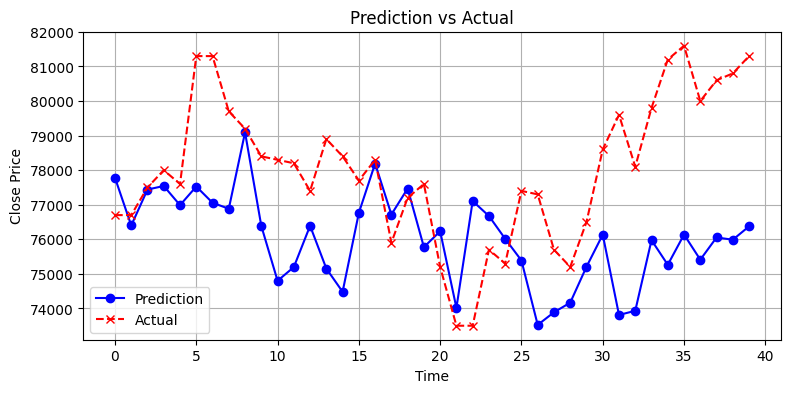

Root Mean Squared Error (RMSE): 3035.9666787659794
*************************************************************************************
[79224.41  77354.91  79473.86  78949.2   78901.83  78714.125 77086.06
 78201.72  78525.22  79273.266 78004.36  78358.164 76201.46  78526.
 79101.92  79064.98  76913.61  80063.96  77191.22  81844.97  79076.75
 80515.47  76053.56  80421.94  79032.09  80710.33  80941.195 78345.234
 77561.68  79369.2   78784.5   77892.016 76282.375 78247.99  78524.22
 77758.414 77407.68  76871.72  77352.2   76820.71 ]
256 6 0.05 5 256


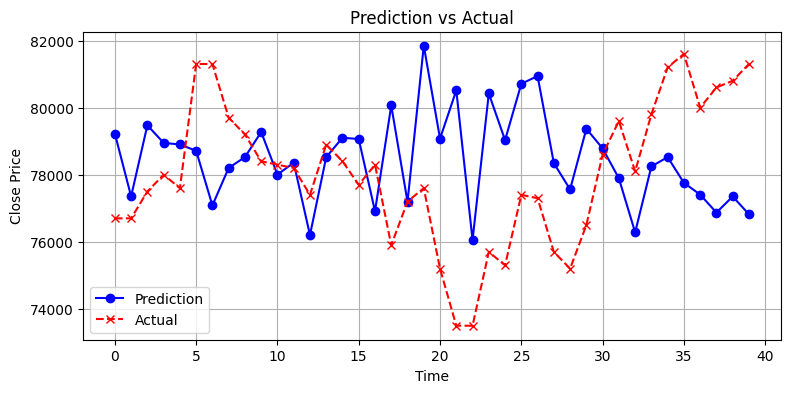

Root Mean Squared Error (RMSE): 2818.2165031208165
*************************************************************************************
[77809.125 77335.36  77966.88  79879.25  78005.5   77573.766 78200.44
 77237.375 76372.56  77231.55  78819.14  77391.1   76963.7   76462.52
 76494.16  77576.84  78004.164 76230.    75446.055 75667.36  76069.78
 76405.29  76336.016 76161.984 76112.34  76578.69  75691.14  75583.875
 75697.81  76336.445 76428.15  75202.69  75479.234 75510.5   75644.56
 75961.44  75538.58  75641.06  77525.266 77475.36 ]
256 6 0.05 8 128


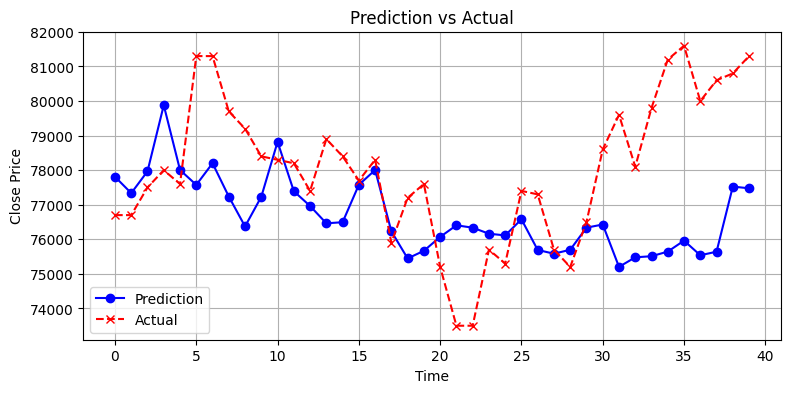

Root Mean Squared Error (RMSE): 2577.1318569888667
*************************************************************************************
[81050.61  79675.555 81134.49  78990.16  79301.59  78845.664 77486.375
 75468.72  77309.78  75931.266 75828.914 77342.86  76353.61  71748.57
 75664.664 77987.71  80112.    78592.36  75855.16  76430.3   77269.86
 77711.86  78470.92  76980.51  78149.45  79075.2   76516.24  76012.64
 77924.59  78108.08  77119.84  77014.82  77375.36  76606.95  75611.09
 76827.23  77612.08  78409.2   79085.46  80286.484]
256 6 0.05 8 256


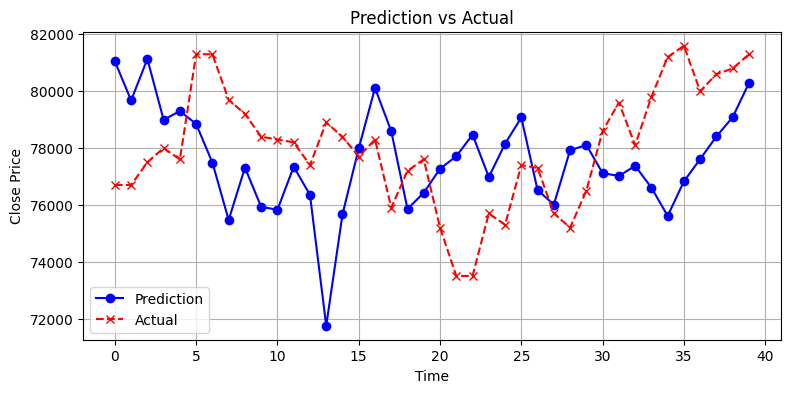

Root Mean Squared Error (RMSE): 2878.6192184263627
*************************************************************************************
[79278.875 78986.39  80147.625 78460.945 78229.64  77955.95  78364.41
 78360.516 78343.45  77711.53  77144.16  80458.41  77295.75  77782.7
 77715.44  77775.164 76663.24  74613.875 78186.25  77473.    78235.875
 78446.66  78029.56  77564.14  76886.08  77205.47  78711.695 74517.875
 73936.234 74241.17  74116.53  77531.875 73940.11  76050.67  77081.33
 77929.19  73951.55  77267.95  76204.17  77485.08 ]
256 8 0.01 4 128


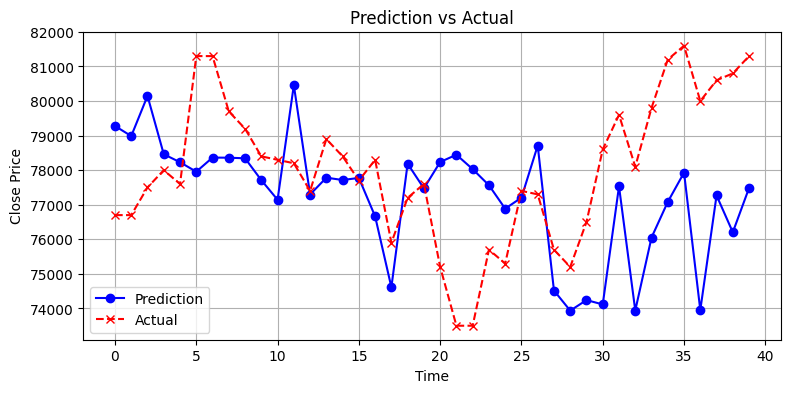

Root Mean Squared Error (RMSE): 2718.6983492893637
*************************************************************************************
[78406.89  79405.59  77515.2   77024.266 77086.13  78319.97  78751.44
 77815.91  77580.03  78117.58  76287.89  77752.64  77159.09  78483.38
 78298.7   76780.5   77921.93  80966.46  79522.79  78367.3   78046.66
 76894.516 78406.72  76454.164 75564.94  77387.42  76411.15  76839.375
 79797.625 76555.17  76751.88  77298.695 75288.164 77283.67  78833.484
 77841.19  77698.84  78373.97  79461.34  80098.85 ]
256 8 0.01 4 256


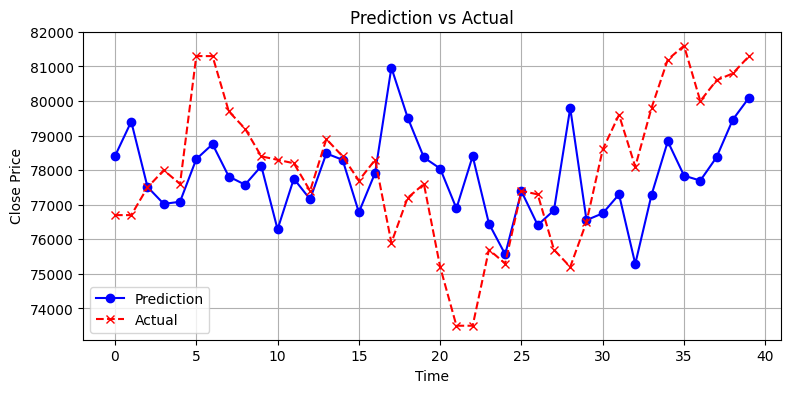

Root Mean Squared Error (RMSE): 2201.968776703606
*************************************************************************************
[79937.266 79286.734 78966.8   77535.66  79576.54  79754.67  78859.34
 78269.28  79834.16  77078.81  77703.36  79467.43  78437.8   75310.25
 78610.195 80171.95  78299.64  77700.484 77433.75  77238.88  76469.17
 76933.84  75152.5   73756.14  75099.39  74996.46  77333.72  74505.
 73855.22  77267.53  74923.95  78413.97  76340.195 78409.55  74703.84
 75371.59  78622.    76013.91  75814.79  77024.5  ]
256 8 0.01 5 128


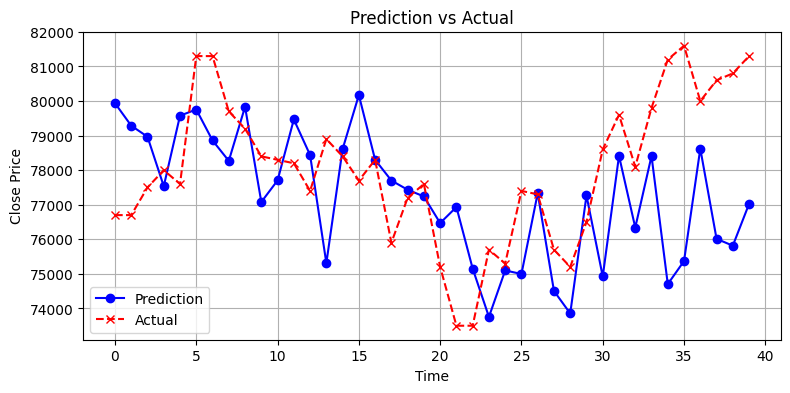

Root Mean Squared Error (RMSE): 2539.9492612438735
*************************************************************************************
[78551.79  77551.22  76870.7   77251.625 79780.69  79031.8   76556.59
 77705.92  76964.2   79230.89  78192.47  76181.85  77932.61  77334.81
 73033.3   77949.445 76322.875 78384.91  81096.734 79316.45  76948.63
 75777.06  79914.81  76192.47  78020.63  79681.04  77983.8   77608.72
 75561.06  79818.87  75876.266 73007.14  77262.06  75957.56  76614.65
 77087.05  75406.44  78749.42  77325.86  77486.375]
256 8 0.01 5 256


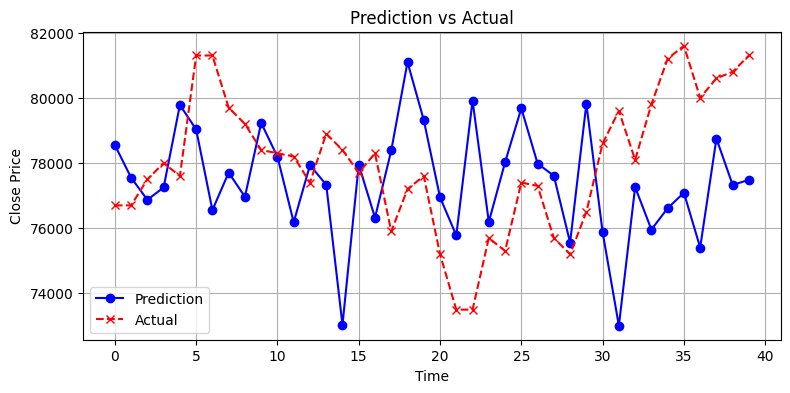

Root Mean Squared Error (RMSE): 2947.243125739378
*************************************************************************************
[78717.6   77618.5   77604.99  77694.836 78847.26  81264.83  74873.695
 77886.97  77628.734 79285.8   79667.92  76272.25  76294.38  72634.375
 74470.125 75295.16  78134.96  79618.92  74853.94  79908.11  79061.89
 78886.64  78292.11  76592.25  78578.55  77056.266 75472.69  77762.58
 76986.84  75182.08  77783.125 74726.17  76716.05  76255.69  75169.28
 77073.55  73712.25  74749.766 76679.086 75462.984]
256 8 0.01 8 128


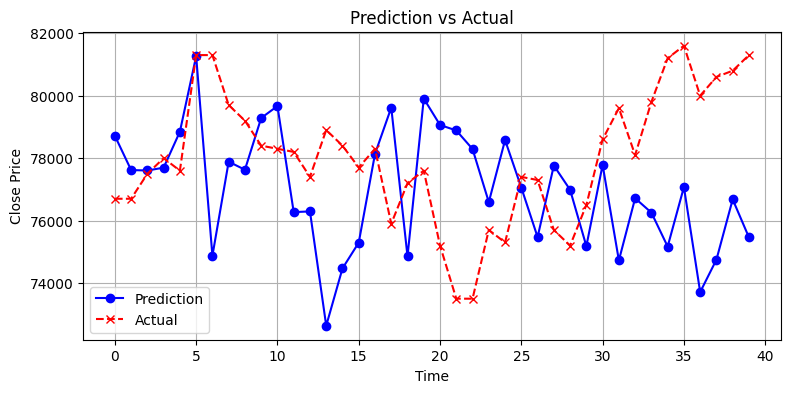

Root Mean Squared Error (RMSE): 3383.9660557155935
*************************************************************************************
[79588.88  80166.17  79111.37  80087.66  79205.625 80071.69  80877.2
 80478.016 78202.59  82218.59  80082.31  80934.    78729.586 80445.94
 78720.16  79893.23  79041.23  81618.14  79526.06  82016.79  79794.51
 80334.84  80567.586 82153.59  80311.766 80496.85  78872.1   78357.41
 80279.19  78828.69  79435.56  81007.625 78720.016 76830.625 77203.836
 80148.375 79943.56  80243.516 81215.375 79572.47 ]
256 8 0.01 8 256


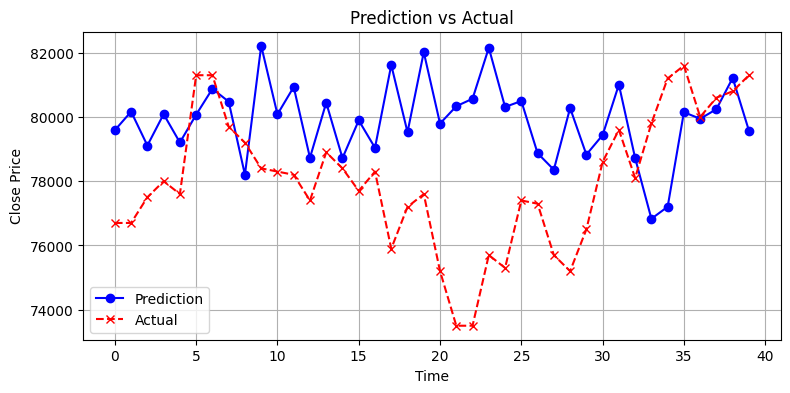

Root Mean Squared Error (RMSE): 3137.5977292751963
*************************************************************************************
[78811.234 79049.22  79112.3   78212.234 79101.516 78270.2   78016.95
 75743.23  75875.555 75844.625 77420.57  77565.35  77348.69  78262.3
 78821.95  77619.31  76704.47  77094.05  78090.86  78191.734 78043.67
 76661.414 76686.24  75662.58  78779.555 76672.67  76591.805 76895.195
 76339.06  76856.64  76092.14  77096.31  75454.45  76601.44  76616.28
 76192.516 77052.07  76715.5   77352.555 78838.69 ]
256 8 0.05 4 128


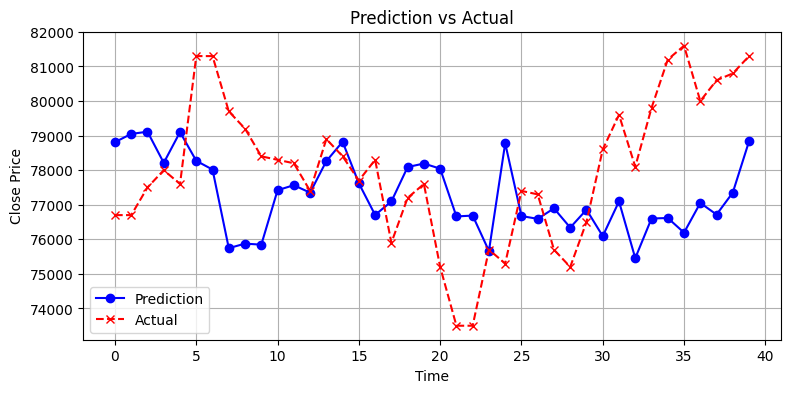

Root Mean Squared Error (RMSE): 2454.299880020082
*************************************************************************************
[79070.06  78744.336 79191.8   76704.33  78576.53  78610.39  79337.3
 78418.45  77526.266 80138.19  79242.625 77538.84  79386.484 77992.625
 79566.766 80309.14  79637.27  77967.15  79971.375 79264.34  79615.66
 79367.15  79050.47  78726.41  77594.54  78692.484 79498.59  78886.72
 79505.875 80499.43  79419.61  77544.8   78086.5   79205.95  79702.75
 80266.74  79417.17  80712.86  79216.53  79676.47 ]
256 8 0.05 4 256


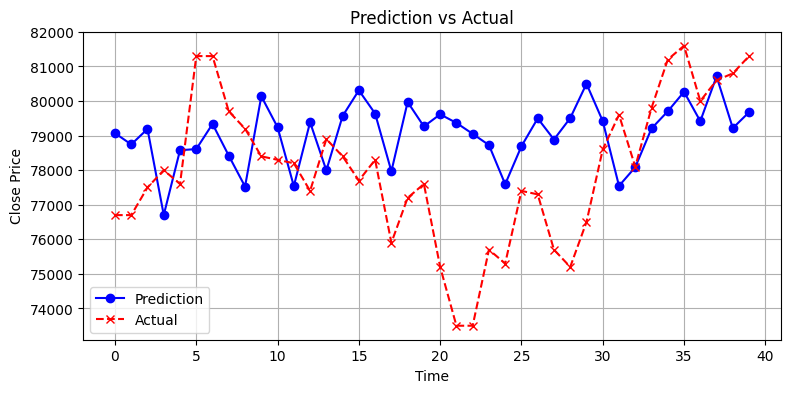

Root Mean Squared Error (RMSE): 2396.511680517258
*************************************************************************************
[78808.625 81839.71  79273.2   78391.84  78357.42  78434.34  76321.19
 77891.555 77362.54  76652.51  77682.03  77305.89  78763.06  76995.66
 79421.97  78200.45  77198.586 78112.766 78745.3   80114.86  78757.83
 76806.984 77653.445 77686.64  78207.35  78765.28  78699.484 78334.68
 78226.91  77121.86  75739.72  76465.91  76184.45  77531.91  77108.11
 76531.87  76186.234 77370.68  76921.266 77556.7  ]
256 8 0.05 5 128


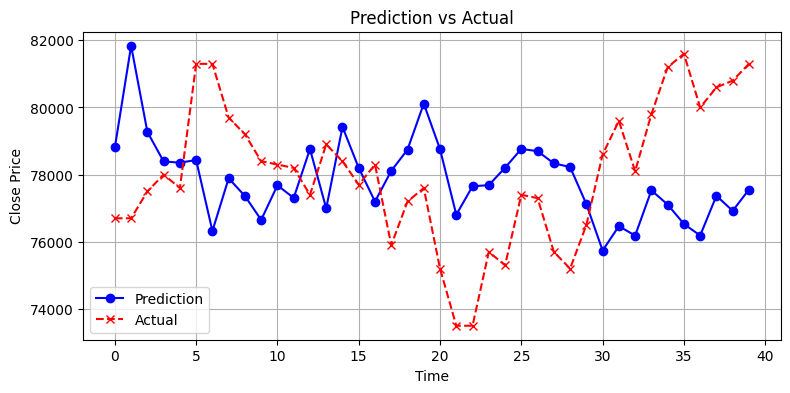

Root Mean Squared Error (RMSE): 2725.1275572562213
*************************************************************************************
[79312.484 78473.97  78351.836 77382.195 79200.48  79334.766 79657.16
 78091.35  77869.27  78932.17  77575.66  78390.79  77413.45  77469.64
 77085.51  77080.29  77441.08  78071.28  77255.5   78322.69  78109.25
 77551.68  76810.83  76441.89  78276.81  77609.375 77283.5   77202.55
 75627.41  77522.766 77359.64  76217.94  78098.16  76595.664 76166.98
 76824.27  76589.27  77373.45  77154.805 77529.1  ]
256 8 0.05 5 256


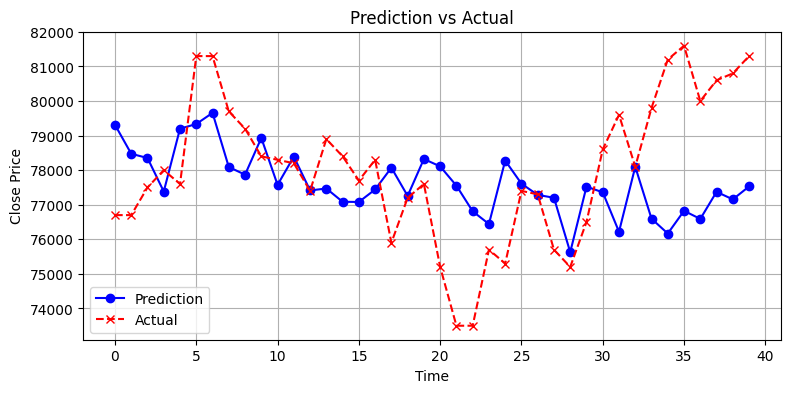

Root Mean Squared Error (RMSE): 2265.272790179297
*************************************************************************************
[79060.89  78738.984 79678.81  77730.28  78751.36  78287.44  77641.59
 79145.81  77127.67  78539.92  76384.5   77270.39  76933.66  77907.56
 76810.69  76151.62  76338.97  77472.48  76381.875 77545.2   74720.48
 75954.28  75389.33  76388.34  76077.23  76451.766 75326.82  73725.69
 74573.13  76374.79  75796.97  75070.484 77659.12  78777.16  79647.81
 76218.93  74891.75  76749.31  74795.59  74028.84 ]
256 8 0.05 8 128


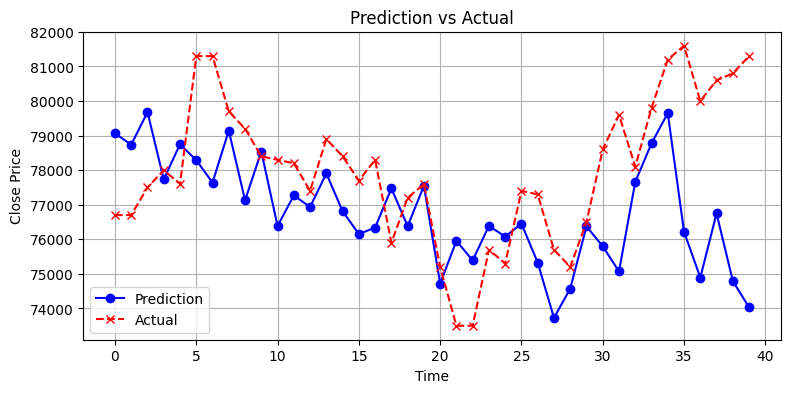

Root Mean Squared Error (RMSE): 2604.95346435716
*************************************************************************************
[77363.47  77458.97  76867.81  78667.664 76889.    79364.875 78052.67
 78399.59  77497.164 78439.266 76803.25  77642.84  77159.56  78128.89
 77717.28  80592.    80858.91  80857.625 80599.22  80113.16  79515.16
 78830.31  80994.61  80279.07  81013.81  80157.75  80553.66  80913.81
 81584.875 80158.5   80716.01  82069.46  80795.29  81000.7   79930.41
 79253.445 79072.22  80396.08  79751.69  81045.76 ]
256 8 0.05 8 256


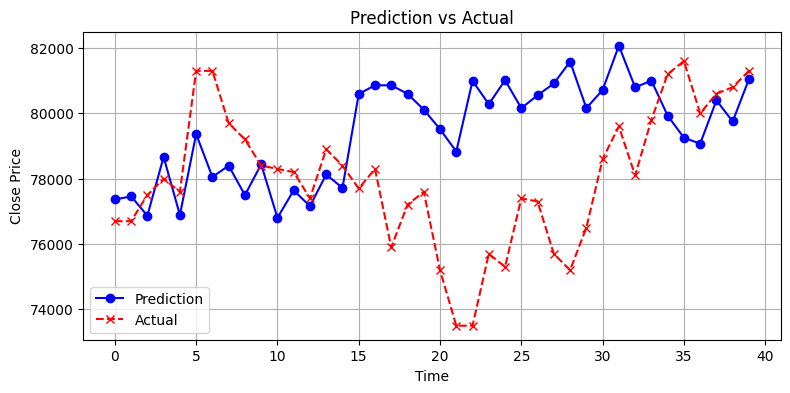

Root Mean Squared Error (RMSE): 3029.3937270784245
*************************************************************************************


In [26]:

for d_model in [90, 128,256]:
    for n_heads in [4,6,8]:
        for drop in [0.01,0.05]:
            for layer in [4,5,8]:
                for diff in [128,256]:
                    eval_model(d_model,n_heads,drop,layer,diff)
                    